In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from viz_utils import *
from dataloaders import *

import os
import pickle
import itertools
import pandas as pd
from collections import defaultdict
from itertools import product

In [2]:
models = ["JWA", "DBERT"]
datasets = ["SUBJ", "SST", "TREC", "IMDB"]
RESULT_PATH = "results/picked"

In [3]:
experiments = load_results(base_dir=RESULT_PATH, dataset="SUBJ", model="DBERT")
# picks, names = get_best_models(experiments)

In [283]:
exs = [(r, m) for (r, m) in experiments if m["tying"] > 0]

In [5]:
ind = 0
results, meta = experiments[ind]
print(meta["conicity"], meta["tying"], meta["l2"])
df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
# plot_experiment(df_tr, df_agr, meta)

0.0 0.0 0.0


In [81]:
def plot_cartography(df, meta, hue_metric="correct", show_hist=True):
    dataframe = cartography_average(df)
    # Subsample data to plot, so the plot is not too busy.
    #     dataframe.sample(
    #         n=25000 if dataframe.shape[0] > 25000 else len(dataframe)
    #     )

    if hue_metric == "correct":
        # Normalize correctness to a value between 0 and 1.
        dataframe = dataframe.assign(
            corr_frac=lambda d: d.correctness / d.correctness.max()
        )
        dataframe = dataframe.sort_values("corr_frac")
        dataframe[hue_metric] = [f"{x:.1f}" for x in dataframe["corr_frac"]]
    elif hue_metric == "forget":
        # Normalize forgetfulness to a value between 0 and 1.
        dataframe = dataframe.assign(
            forg_frac=lambda d: d.forgetfulness / d.forgetfulness.max()
        )
        dataframe = dataframe.sort_values("forg_frac")
        dataframe[hue_metric] = [f"{x:.1f}" for x in dataframe["forg_frac"]]
    else:
        raise ValueError(
            f"Hue metric {hue_metric} is not supported. Choose from ['correct', 'forget']."
        )

    main_metric = "variability"
    other_metric = "confidence"

    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(10, 5))
        ax0 = axs
    else:
        fig = plt.figure(
            figsize=(16, 10),
        )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])

        ax0 = fig.add_subplot(gs[0, :])

    ### Make the scatterplot.

    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(
        x=main_metric,
        y=other_metric,
        ax=ax0,
        data=dataframe,
        hue=hue,
        palette=pal,
        style=style,
        s=200,
    )

    # Annotate Regions.
#     bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
#     an1 = ax0.annotate(
#         "ambiguous",
#         xy=(0.9, 0.5),
#         xycoords="axes fraction",
#         fontsize=15,
#         color="black",
#         va="center",
#         ha="center",
#         bbox=bb("black"),
#     )
#     an2 = ax0.annotate(
#         "easy-to-learn",
#         xy=(0.27, 0.85),
#         xycoords="axes fraction",
#         fontsize=15,
#         color="black",
#         va="center",
#         ha="center",
#         bbox=bb("r"),
#     )
#     an3 = ax0.annotate(
#         "hard-to-learn",
#         xy=(0.35, 0.25),
#         xycoords="axes fraction",
#         fontsize=15,
#         color="black",
#         va="center",
#         ha="center",
#         bbox=bb("b"),
#     )

    if not show_hist:
        plot.legend(
            ncol=num_hues,
            bbox_to_anchor=(0.5, -0.38),
            loc="center",
            fancybox=True,
            shadow=True,
            title="Correctness",
            markerscale=1.5,
        )
        
    
        leg = ax0.get_legend()
        leg._legend_box.align = "left"
    else:
        plot.legend(fancybox=True, shadow=True, ncol=1)

    if show_hist:
        plot.set_title(
            f"{meta['dataset']} Data Map - {meta['model']} model - {len(df)} datapoints",
            fontsize=17,
        )

        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=["confidence"], ax=ax1, color="#622a87")
        plott0[0].set_title("")
        plott0[0].set_xlabel("Confidence")
        plott0[0].set_ylabel("density")

        plott1 = dataframe.hist(column=["variability"], ax=ax2, color="teal")
        plott1[0].set_title("")
        plott1[0].set_xlabel("Variability")

        if hue_metric == "correct":
            plot2 = sns.countplot(x="correct", data=dataframe, color="#86bf91", ax=ax3)
            ax3.xaxis.grid(True)  # Show the vertical gridlines

            plot2.set_title("")
            plot2.set_xlabel("correctness")
            plot2.set_ylabel("")

        else:
            plot2 = sns.countplot(x="forget", data=dataframe, color="#86bf91", ax=ax3)
            ax3.xaxis.grid(True)  # Show the vertical gridlines

            plot2.set_title("")
            plot2.set_xlabel("forgetfulness")
            plot2.set_ylabel("")

    fig.tight_layout()
    return fig


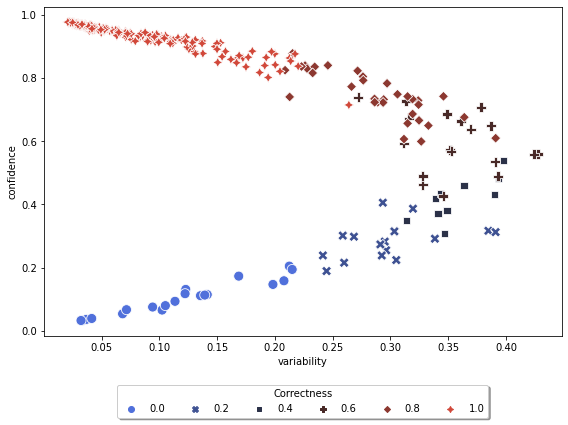

In [223]:

# fig.savefig(f"cart_subj_dbert_corr.pdf", format="pdf", bbox_inches="tight")

In [6]:
df_agr["pearson_r"]

agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.553037   
           1     (deeplift, deeplift-shap)   0.533748   
           2     (deeplift, deeplift-shap)   0.436626   
           3     (deeplift, deeplift-shap)   0.419862   
           4     (deeplift, deeplift-shap)   0.437442   
...                                               ...   
4          0     (grad-shap, int-grad)       0.679981   
           1     (grad-shap, int-grad)       0.651233   
           2     (grad-shap, int-grad)       0.657310   
           3     (grad-shap, int-grad)       0.602780   
           4     (grad-shap, int-grad)       0.591856   

                                                                                  correlation  \
experiment epoch interpreter                                                                    
0          0     (deeplift, deeplift-shap)  [0.6555055431562564, 0.7432211125119028, 0.804...   
           1     (deeplift, deeplift-shap)  [0.6693074537905599, 0.6818941622094178, 0.771...   
           2     (deeplift, deeplift-shap)  [0.45806547269664244, 0.44729330282853363, 0.7...   
           3     (deeplift, deeplift-shap)  [0.37145622536481115, 0.3237849746337649, 0.87...   
           4     (deeplift, deeplift-shap)  [0.2787752489081594, 0.4327943863947006, 0.695...   
...                                                                                       ...   
4          0     (grad-shap, int-grad)      [0.8490491981872492, 0.8449594749354046, -0.08...   
           1     (grad-shap, int-grad)      [0.7568203528302615, 0.8512178261947412, 0.414...   
           2     (grad-shap, int-grad)      [0.6535759119684837, 0.8523022881205334, 0.856...   
           3     (grad-shap, int-grad)      [0.7523857670597238, 0.25431157227900036, 0.86...   
           4     (grad-shap, int-grad)      [0.518288259604938, 0.7598887328541704, 0.7208...   

                                              measure  
experiment epoch interpreter                           
0          0     (deeplift, deeplift-shap)  pearson_r  
           1     (deeplift, deeplift-shap)  pearson_r  
           2     (deeplift, deeplift-shap)  pearson_r  
           3     (deeplift, deeplift-shap)  pearson_r  
           4     (deeplift, deeplift-shap)  pearson_r  
...                                               ...  
4          0     (grad-shap, int-grad)      pearson_r  
           1     (grad-shap, int-grad)      pearson_r  
           2     (grad-shap, int-grad)      pearson_r  
           3     (grad-shap, int-grad)      pearson_r  
           4     (grad-shap, int-grad)      pearson_r  

[150 rows x 3 columns]

In [7]:
df_agr_avg = agreement_average(df_agr["jsd"])

In [8]:
df_agr_avg

agreement  \
epoch interpreter                             
0     (deeplift, deeplift-shap)    0.733433   
      (deeplift, grad-shap)        0.687812   
      (deeplift, int-grad)         0.696567   
      (deeplift-shap, grad-shap)   0.699995   
      (deeplift-shap, int-grad)    0.710308   
      (grad-shap, int-grad)        0.783176   
1     (deeplift, deeplift-shap)    0.713536   
      (deeplift, grad-shap)        0.667904   
      (deeplift, int-grad)         0.674587   
      (deeplift-shap, grad-shap)   0.676427   
      (deeplift-shap, int-grad)    0.684528   
      (grad-shap, int-grad)        0.771596   
2     (deeplift, deeplift-shap)    0.700580   
      (deeplift, grad-shap)        0.652721   
      (deeplift, int-grad)         0.658051   
      (deeplift-shap, grad-shap)   0.657091   
      (deeplift-shap, int-grad)    0.663092   
      (grad-shap, int-grad)        0.760393   
3     (deeplift, deeplift-shap)    0.697156   
      (deeplift, grad-shap)        0.651265   
      (deeplift, int-grad)         0.657072   
      (deeplift-shap, grad-shap)   0.656860   
      (deeplift-shap, int-grad)    0.662910   
      (grad-shap, int-grad)        0.750697   
4     (deeplift, deeplift-shap)    0.690514   
      (deeplift, grad-shap)        0.647901   
      (deeplift, int-grad)         0.654438   
      (deeplift-shap, grad-shap)   0.652865   
      (deeplift-shap, int-grad)    0.659296   
      (grad-shap, int-grad)        0.742757   

                                                                        correlation  \
epoch interpreter                                                                     
0     (deeplift, deeplift-shap)   [0.7328792637751965, 0.7391060600392715, 0.743...   
      (deeplift, grad-shap)       [0.7181304404851384, 0.697684152797947, 0.6979...   
      (deeplift, int-grad)        [0.7250803327837329, 0.7023277809755394, 0.737...   
      (deeplift-shap, grad-shap)  [0.7389039489569853, 0.72779163333644, 0.68838...   
      (deeplift-shap, int-grad)   [0.7534817858587172, 0.7391602354512645, 0.746...   
      (grad-shap, int-grad)       [0.7918770472600246, 0.8126225169251926, 0.736...   
1     (deeplift, deeplift-shap)   [0.705134760233649, 0.7122839406285901, 0.7430...   
      (deeplift, grad-shap)       [0.6550384162564029, 0.6571084483647869, 0.698...   
      (deeplift, int-grad)        [0.6632355752425058, 0.6534959311674259, 0.698...   
      (deeplift-shap, grad-shap)  [0.6550051649543486, 0.655865559327961, 0.7230...   
      (deeplift-shap, int-grad)   [0.6681352281091893, 0.6638166415911076, 0.740...   
      (grad-shap, int-grad)       [0.7916855178764048, 0.792681255154448, 0.7572...   
2     (deeplift, deeplift-shap)   [0.6920547616737492, 0.6935758866514545, 0.725...   
      (deeplift, grad-shap)       [0.6513189642410049, 0.6143907186961517, 0.694...   
      (deeplift, int-grad)        [0.6466144502737399, 0.6086939354880002, 0.694...   
      (deeplift-shap, grad-shap)  [0.6467695391822262, 0.6344584554009596, 0.694...   
      (deeplift-shap, int-grad)   [0.6332724443525051, 0.6361933634066013, 0.708...   
      (grad-shap, int-grad)       [0.7462322443503491, 0.8006105942306239, 0.783...   
3     (deeplift, deeplift-shap)   [0.6746878292275247, 0.6869069170604791, 0.713...   
      (deeplift, grad-shap)       [0.6159016475611772, 0.5983553065057394, 0.673...   
      (deeplift, int-grad)        [0.6265608890131018, 0.6081802670209481, 0.665...   
      (deeplift-shap, grad-shap)  [0.6231569012687599, 0.6303472983410149, 0.669...   
      (deeplift-shap, int-grad)   [0.6358054682338501, 0.6280954936047797, 0.664...   
      (grad-shap, int-grad)       [0.7707505811391072, 0.7575230485171515, 0.796...   
4     (deeplift, deeplift-shap)   [0.6456347003455465, 0.6841886729885183, 0.728...   
      (deeplift, grad-shap)       [0.6222194673982834, 0.6418179111100966, 0.662...   
      (deeplift, int-grad)        [0.6273399719698154, 0.6345751016030386, 0.672...   
      

In [9]:

corrs.size

NameError: name 'corrs' is not defined

In [10]:
corrs = df_agr_avg.iloc[-4].correlation
fig = acs(df_crt_test, meta, corrs, subsample=600, show_hist=False, rs=5)
fig.savefig(f"cart_subj_dbert_agr.pdf", format="pdf", bbox_inches="tight")

NameError: name 'acs' is not defined

In [126]:
df_agr_avg

NameError: name 'df_agr_avg' is not defined

In [158]:
def scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [159]:
sns.color_palette("rocket", 10)

[(0.13501631, 0.07585609, 0.19044109),
 (0.26930915, 0.1091727, 0.2772502),
 (0.41282936, 0.12164769, 0.33467689),
 (0.57077365, 0.11135597, 0.35827146),
 (0.72398193, 0.08688725, 0.33943958),
 (0.85281737, 0.15657772, 0.27909826),
 (0.93078135, 0.31373977, 0.24468803),
 (0.95626788, 0.49187351, 0.33985601),
 (0.96388426, 0.64484214, 0.4861196),
 (0.96810471, 0.78634563, 0.66773889)]

In [11]:
def plot_agreement_cartography(df, meta, agreement, show_hist=True):
    dataframe = cartography_average(df)
    dataframe["agreement"] = agreement
    dataframe = dataframe.sort_values("agreement")
    dataframe = dataframe[dataframe.agreement >= 0.]
    dataframe["agreement"] = [f"{x:.1f}" for x in dataframe["agreement"]]
 
    
    dataframe = dataframe.assign(
            corr_frac=lambda d: d.correctness / d.correctness.max()
        )
    dataframe["correct"] = [f"{x:.1f}" for x in dataframe["corr_frac"]]
    

    main_metric = "variability"
    other_metric = "confidence"
    
    hue = "agreement"
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(
            figsize=(16, 10),
        )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])

        ax0 = fig.add_subplot(gs[0, :])

    ### Make the scatterplot.

    # Choose a palette.
    pal = sns.color_palette("magma", num_hues)
#     pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(
        x=main_metric,
        y=other_metric,
        ax=ax0,
        data=dataframe,
        hue=hue,
        palette=pal,
        style=style,
        s=30,
    )

    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    an1 = ax0.annotate(
        "ambiguous",
        xy=(0.9, 0.5),
        xycoords="axes fraction",
        fontsize=15,
        color="black",
        va="center",
        ha="center",
        bbox=bb("black"),
    )
    an2 = ax0.annotate(
        "easy-to-learn",
        xy=(0.27, 0.85),
        xycoords="axes fraction",
        fontsize=15,
        color="black",
        va="center",
        ha="center",
        bbox=bb("r"),
    )
    an3 = ax0.annotate(
        "hard-to-learn",
        xy=(0.35, 0.25),
        xycoords="axes fraction",
        fontsize=15,
        color="black",
        va="center",
        ha="center",
        bbox=bb("b"),
    )

    if not show_hist:
        plot.legend(
            ncol=1,
            bbox_to_anchor=(1.01, 0.5),
            loc="center left",
            fancybox=True,
            shadow=True,
        )
    else:
        plot.legend(fancybox=True, shadow=True, ncol=1)
    plot.set_xlabel("variability")
    plot.set_ylabel("confidence")

    if show_hist:
        plot.set_title(
            f"{meta['dataset']} Data Map - {meta['model']} model - {len(df)} datapoints",
            fontsize=17,
        )

        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=["confidence"], ax=ax1, color="#622a87")
        plott0[0].set_title("")
        plott0[0].set_xlabel("confidence")
        plott0[0].set_ylabel("density")

        plott1 = dataframe.hist(column=["variability"], ax=ax2, color="teal")
        plott1[0].set_title("")
        plott1[0].set_xlabel("variability")

        plot2 = sns.countplot(x="correct", data=dataframe, color="#86bf91", ax=ax3)
        ax3.xaxis.grid(True)  # Show the vertical gridlines

        plot2.set_title("")
        plot2.set_xlabel("correctness")
        plot2.set_ylabel("")


    fig.tight_layout()
    return fig

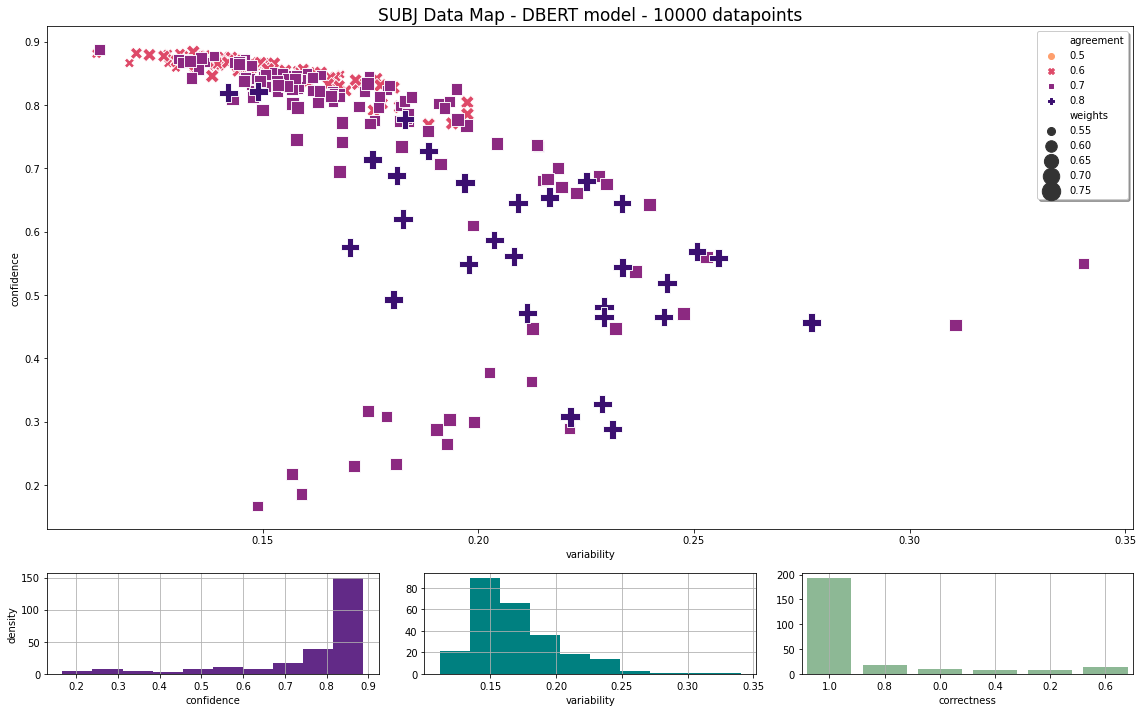

In [47]:
fig = plot_agreement_cartography_size(df_crt_test, meta, corrs, subsample=250)

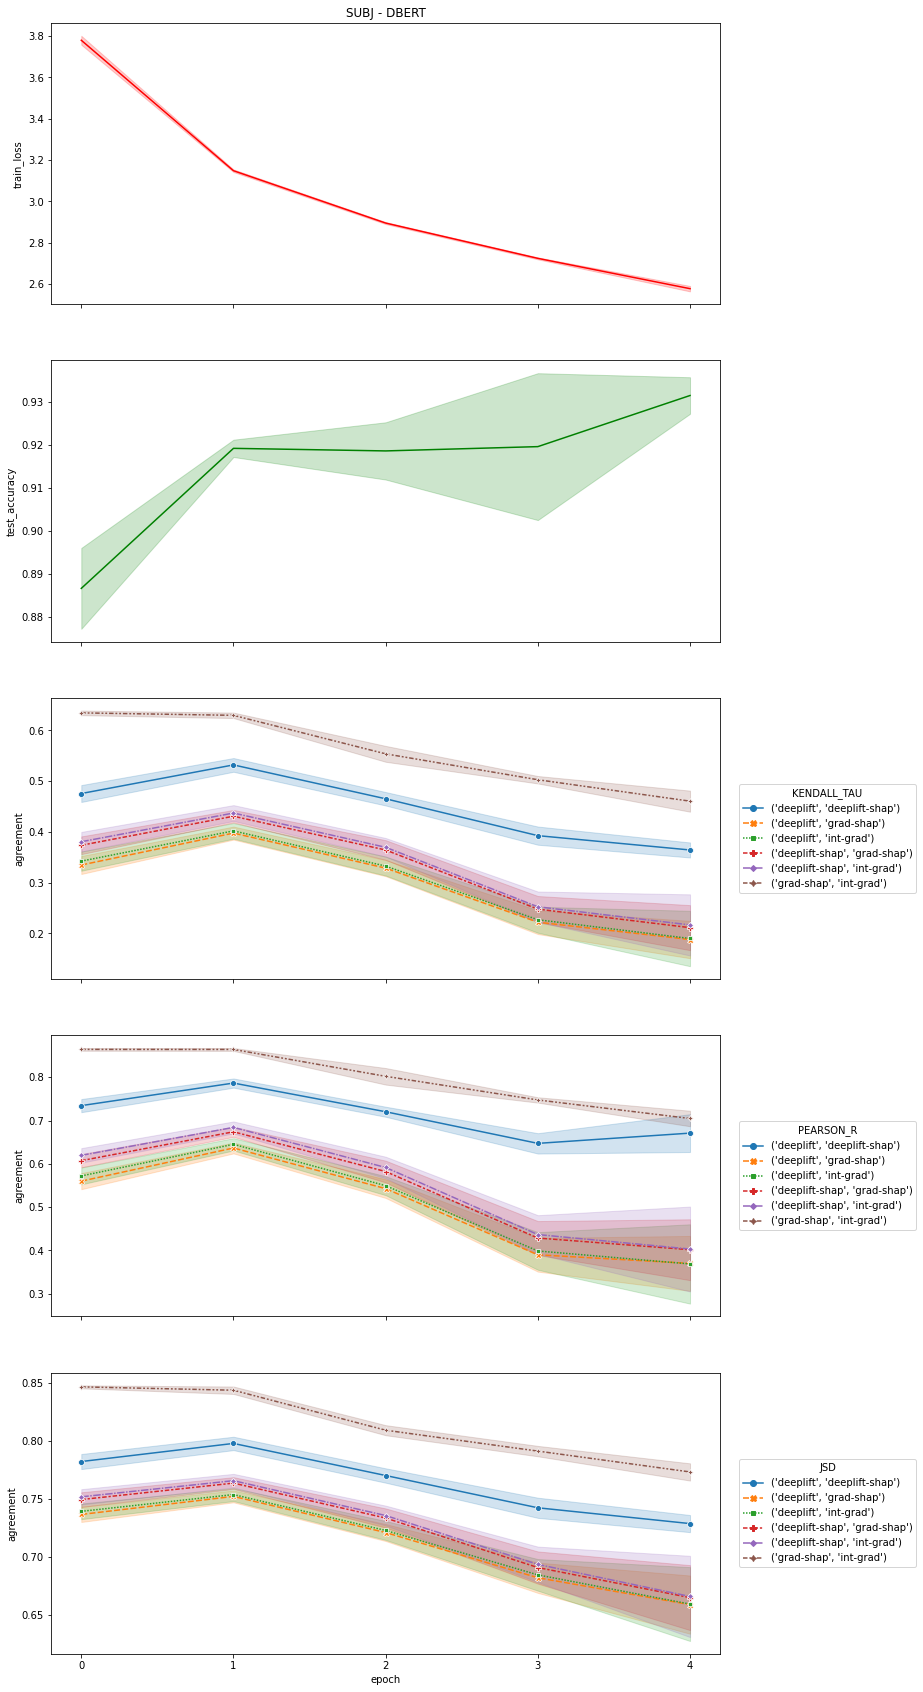

In [285]:
plot_experiment(df_tr, df_agr, meta)

0.0 10.0


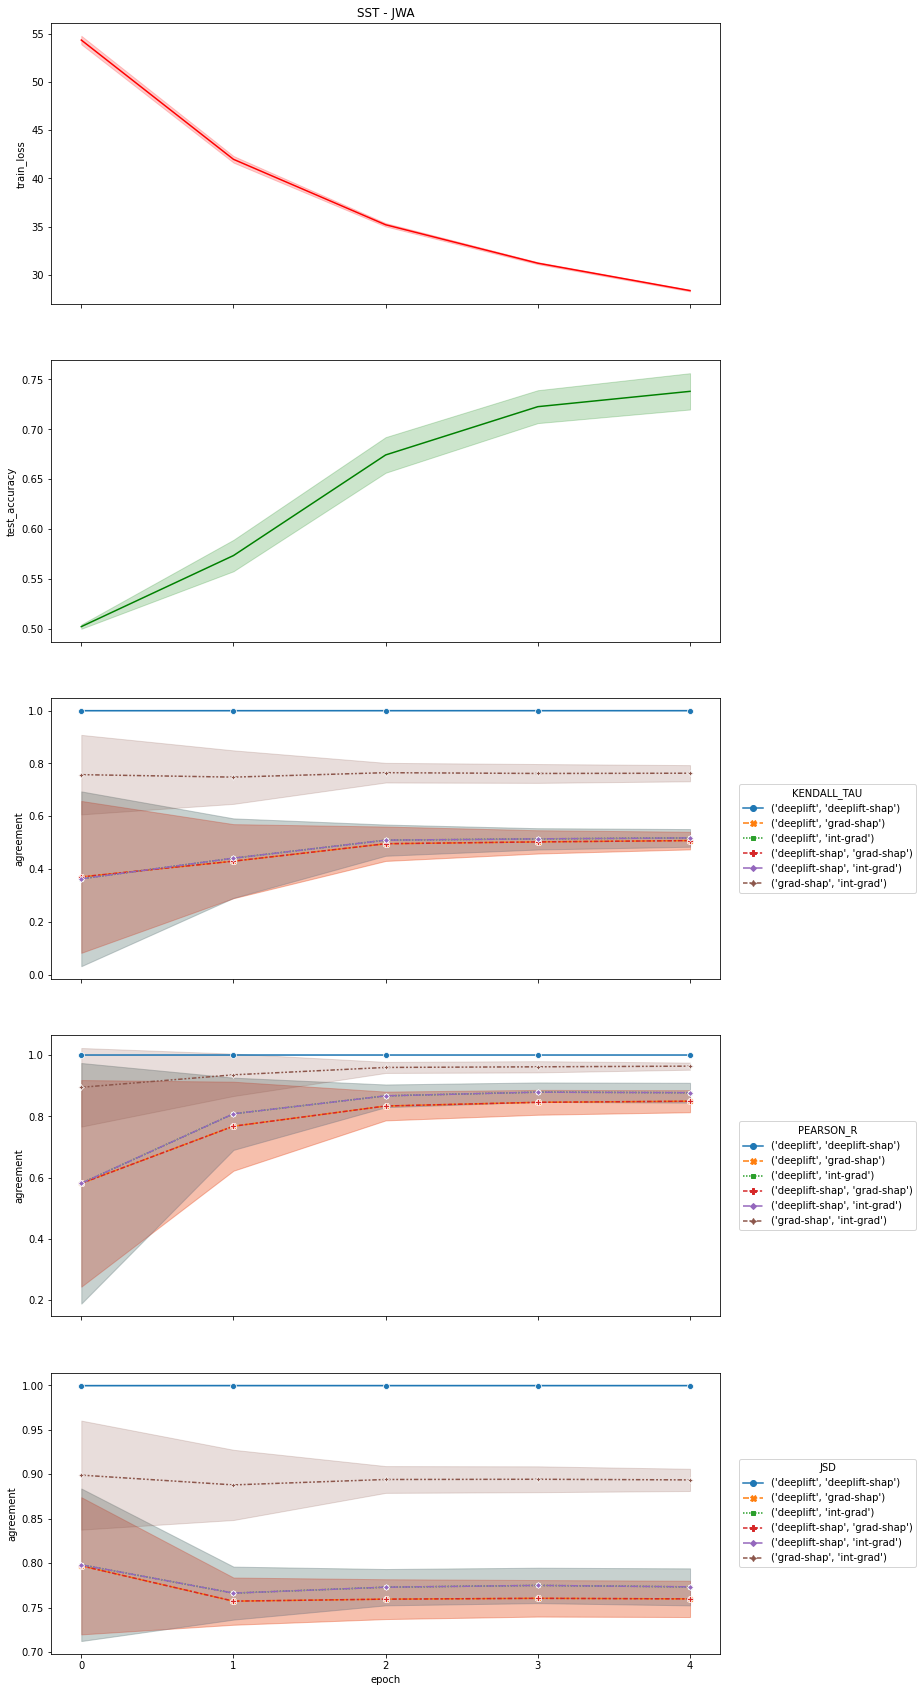

In [9]:
ind = 4
result, meta = experiments[ind]
print(meta["conicity"], meta["tying"])
df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(result, meta)
plot_experiment(df_tr, df_agr, meta)

In [107]:
def pick_best(exps):
    best = None
    for exp in exps:
        if not best or get_final_accuracy(exp) > get_final_accuracy(best):
            best = exp
    return best

def get_best_models(experiments):
    nonreg = [
        ex
        for ex in experiments
        if ex[1]["conicity"] == 0 and ex[1]["tying"] == 0 and ex[1]["l2"] == 0
    ]
    conicity = [ex for ex in experiments if ex[1]["conicity"] > 0]
    tying = [ex for ex in experiments if ex[1]["tying"] > 0]
    l2 = [ex for ex in experiments if ex[1]["l2"] > 0]

    nonreg_pick = pick_best(nonreg)
    con_pick = pick_best(conicity)
    tying_pick = pick_best(tying)
    l2_pick = pick_best(l2)
    
    return (nonreg_pick, con_pick, tying_pick, l2_pick), [
        "base",
        "conicity",
        "tying",
        "l2",
    ]

In [38]:
def plot_agreement_matrix(
    experiments, models, num_meas=2, figsize=(16, 10), set_title=True, set_legend=True
):
    fig, axs = plt.subplots(num_meas, len(experiments), figsize=figsize, sharey=True)
    fig.subplots_adjust(hspace=0.4)
    for j, ((results, meta), model) in enumerate(zip(experiments, models)):
        df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
        num_meas = len(df_agr)
        lines = []

        for i, (k, v) in enumerate(df_agr.items()):
            if k == "jsd":
                continue
            g = sns.lineplot(
                ax=axs[i][j],
                data=v,
                x="epoch",
                y="agreement",
                hue="interpreter",
                style="interpreter",
                ci="sd",
                markers=True,
                dashes=True,
            )
            if set_title:
                g.set_title(f"{model} -- {k.upper()}")
            handles, labels = axs[i][j].get_legend_handles_labels()
            axs[i][j].get_legend().remove()
            g.set(xticks=range(meta["epochs_per_train"]))

        if set_legend and j == 2:
            handles, labels = axs[i-1][j].get_legend_handles_labels()
            g.legend(handles, labels)
            g.legend(loc="center", bbox_to_anchor=(0, -0.8), ncol=1, markerscale=1.5)
    plt.show()
    return fig

In [39]:
def agreement_average(df):
    grouped = df.groupby(level=[1, 2])
    new_df = pd.DataFrame()
    new_df["agreement"] = grouped.agreement.agg(np.mean)
    new_df["correlation"] = grouped.correlation.agg(np.mean)
    new_df["std"] = grouped.agreement.agg(np.std)
    return new_df

JWA -- SUBJ


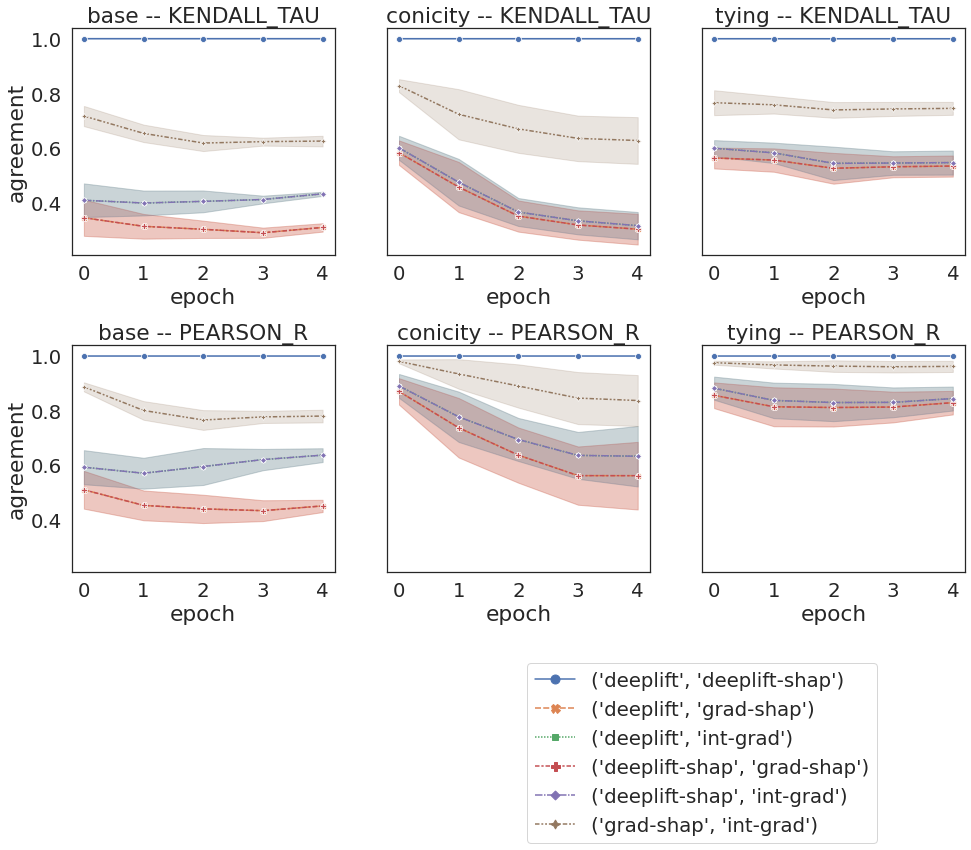

JWA -- SST


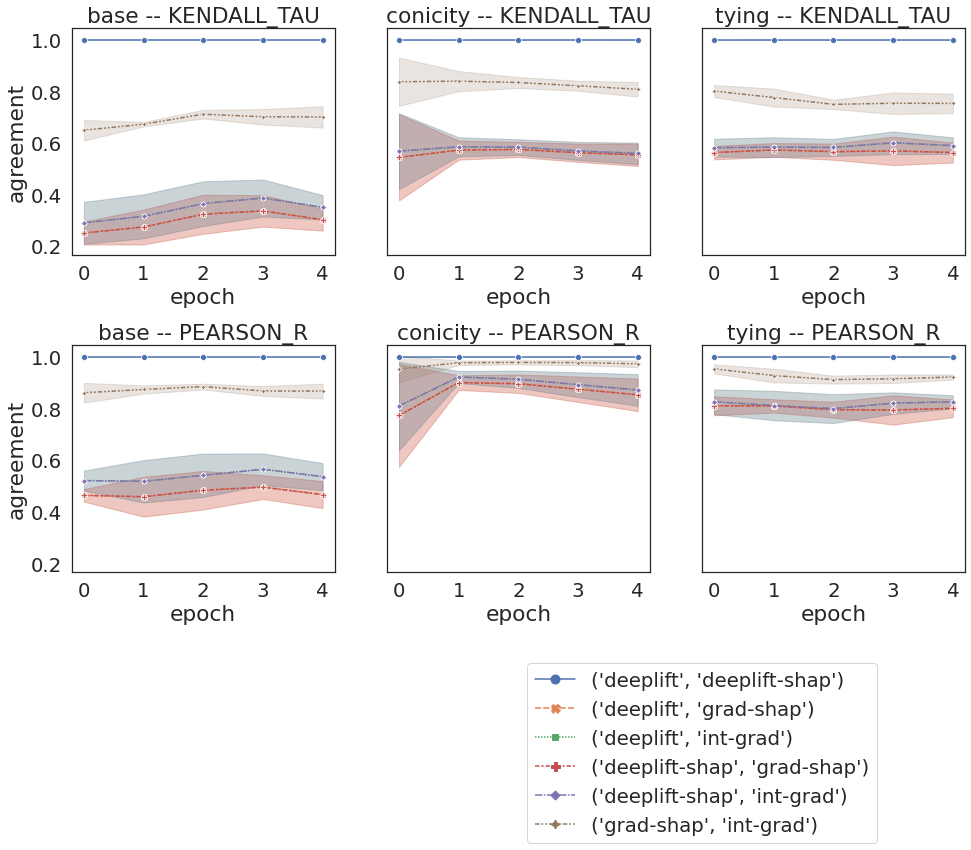

JWA -- TREC


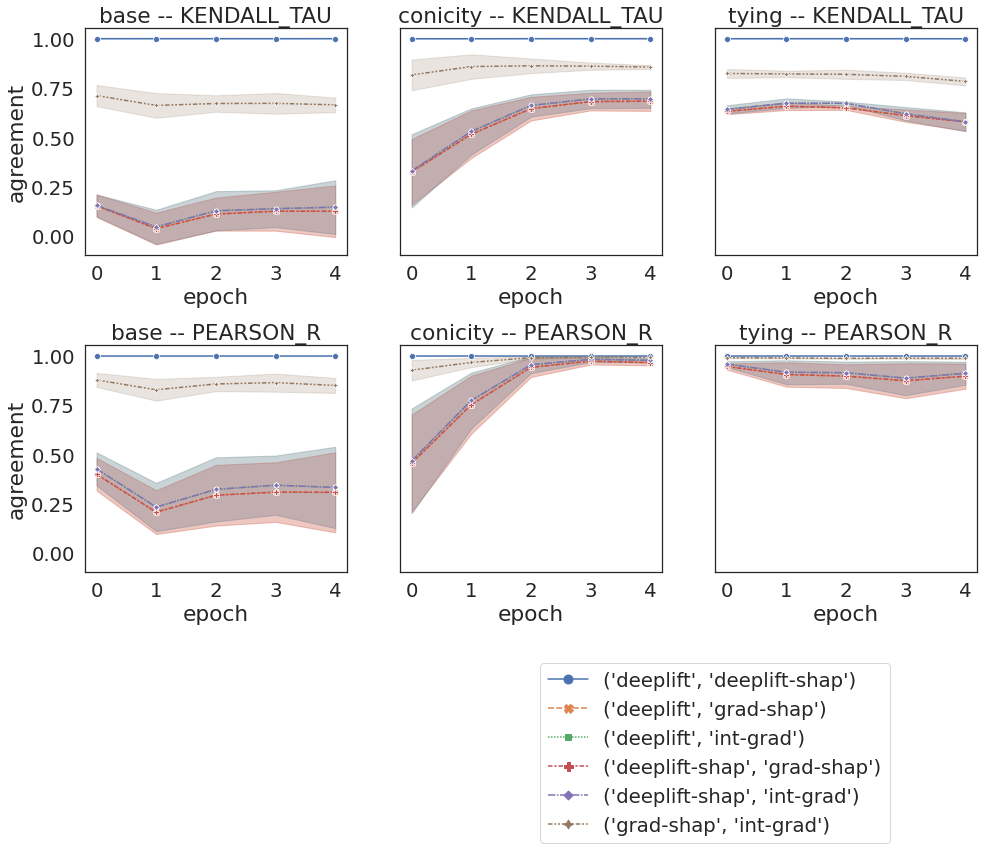

JWA -- IMDB


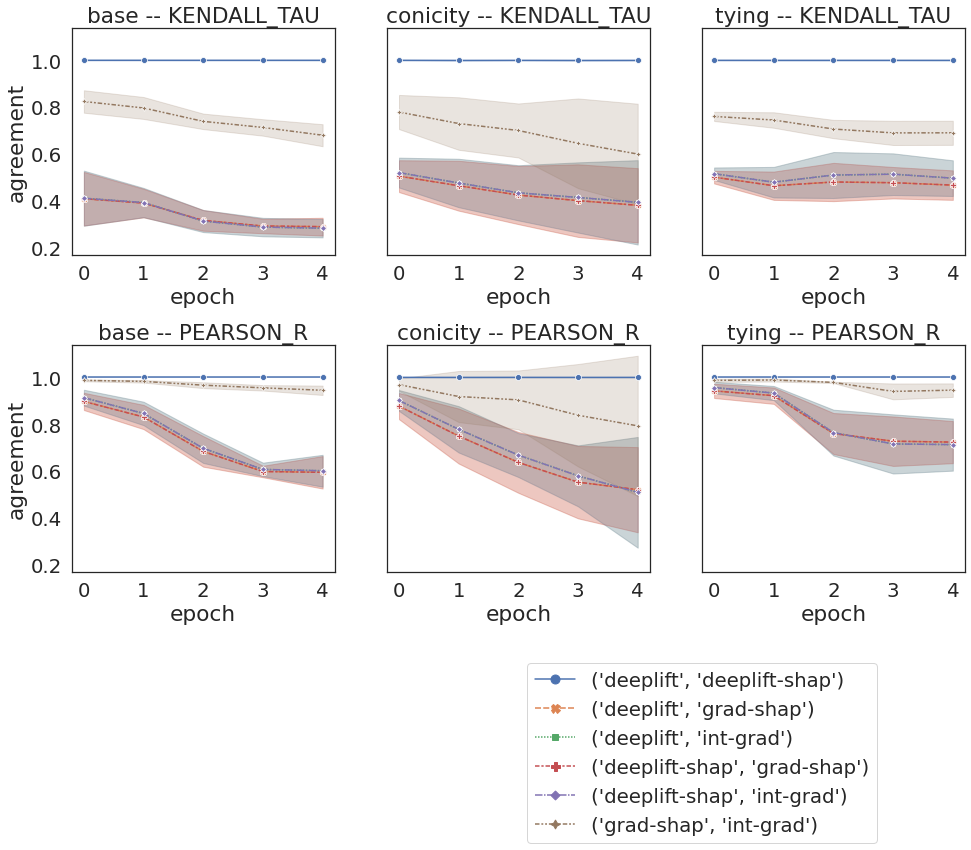

DBERT -- SUBJ


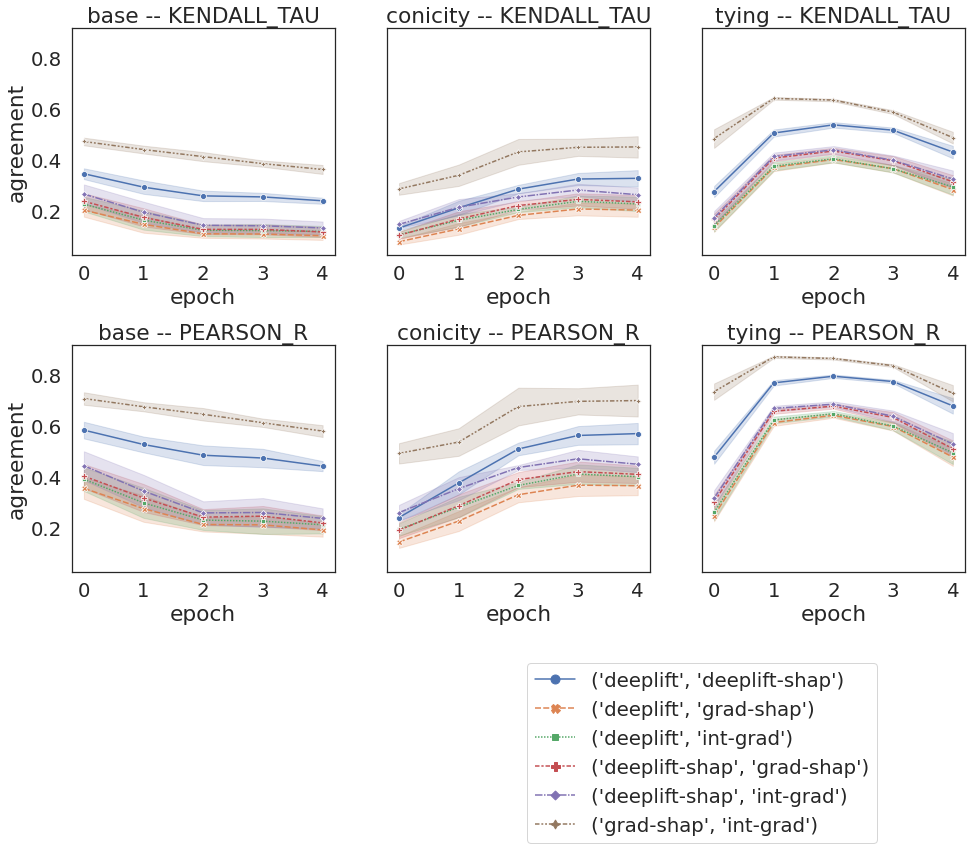

DBERT -- SST


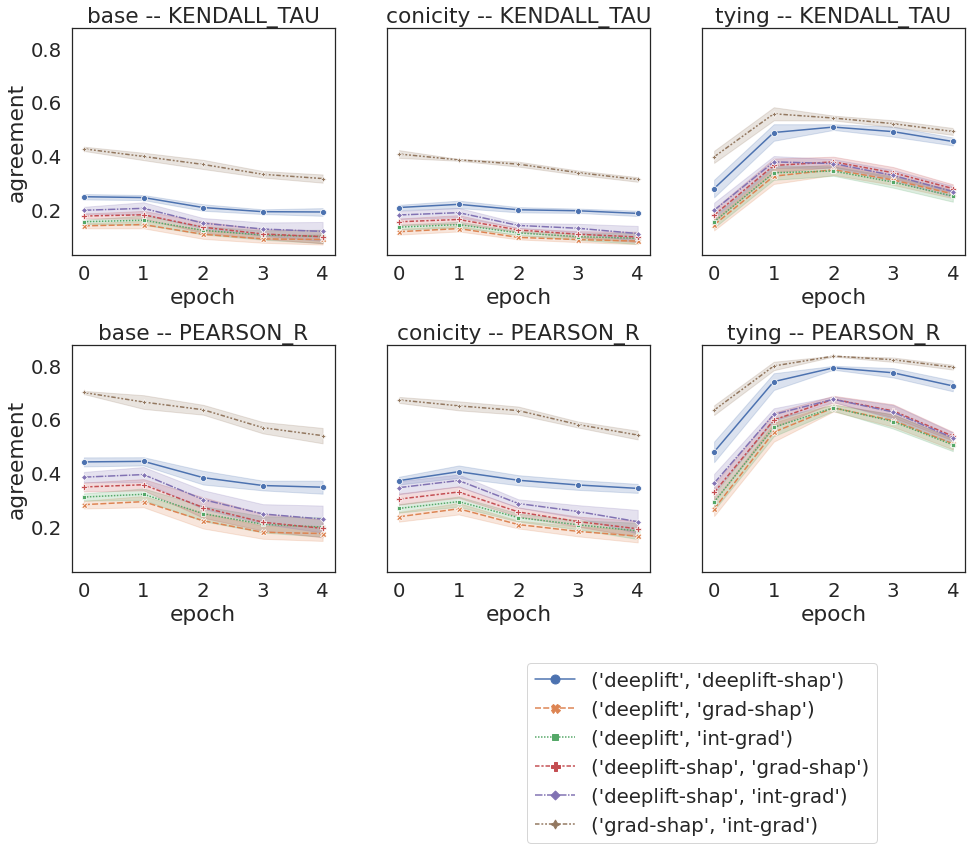

DBERT -- TREC


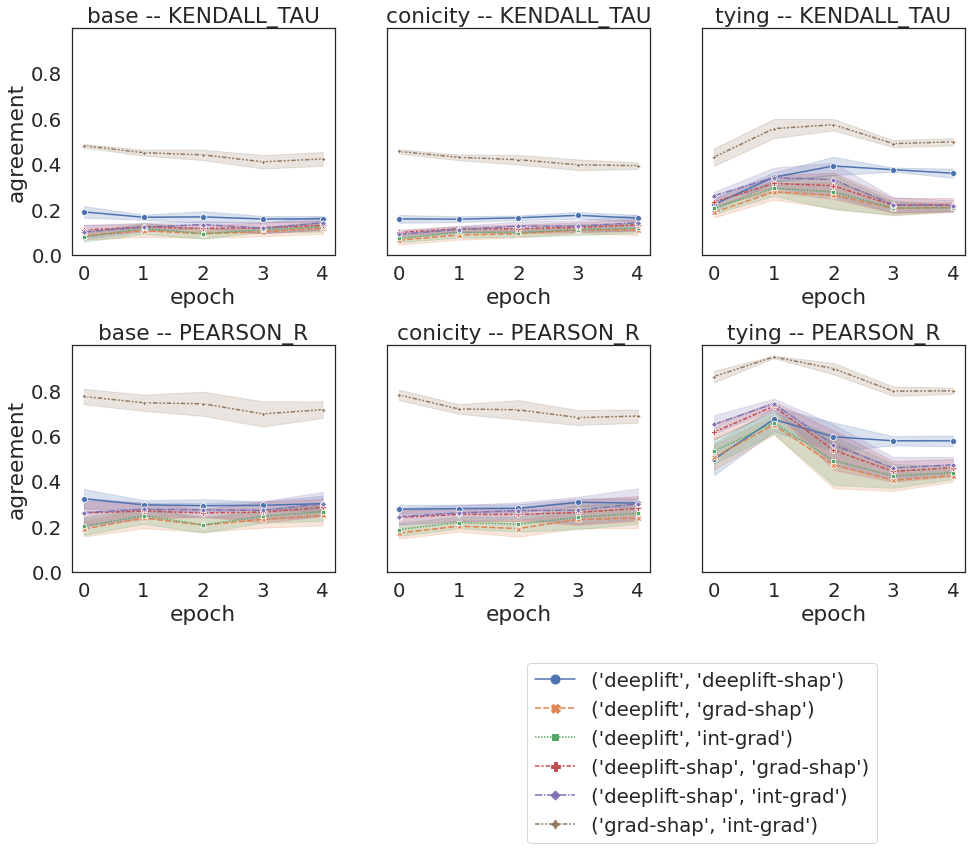

DBERT -- IMDB


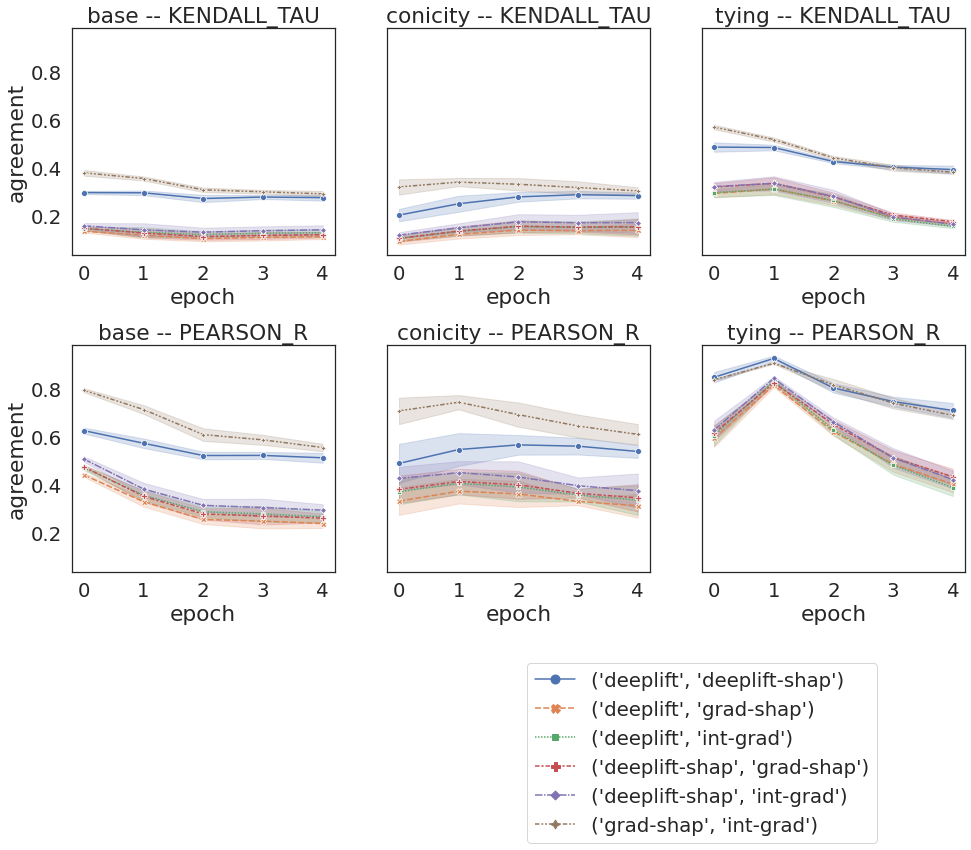

In [40]:
sns.set(font_scale = 1.8)
sns.set_style("white")


for model, dataset in product(models, datasets):
    print(f"{model} -- {dataset}")
    print("="*100)
    experiments = load_results(base_dir=RESULT_PATH, dataset=dataset, model=model)
    picks, names = get_best_models(experiments)
    names = ["base", "conicity", "tying"]
    fig = plot_agreement_matrix(picks[:-1], names)
    fig.savefig(f"{model}-{dataset}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [16]:
for model, dataset in product(models, datasets):
    print(f"{model} -- {dataset}")
    print("="*100)
    experiments = load_results(base_dir=RESULT_PATH, dataset=dataset, model=model)
    picks, names = get_best_models(experiments)
    names = []
    for (results, meta), name in zip(picks, names):
        df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
        df_avg = agreement_average(df_agr["kendall_tau"])
        agr = df_avg[df_avg.index.get_level_values(0) == 4].agreement
        print(f"[{name.upper()}] Mean: {agr.mean().round(2)}, std: {agr.std():.3f}")
        print(name)

JWA -- SUBJ
JWA -- SST


KeyboardInterrupt: 

In [121]:
def plot_attribute_matrix(
    experiments,
    models,
    figsize=(12, 4),
    attributes=[
        "correctness",
        "confidence",
        "variability",
        "forgetfulness",
        "threshold_closeness",
    ],
    print_flag=False,
):
    fig, axs = plt.subplots(
        1, len(attributes), figsize=figsize, sharex=True, sharey=True,
    )
    fig.subplots_adjust(wspace=0.5)
    
    for j, attribute in enumerate(attributes):
        
        mean_dfs = []
        for i, ((results, meta), model) in enumerate(zip(experiments, models)):
            df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
            df_crt_avg = cartography_average(df_crt_test)
            dfs = []
            for corr_meas, df_agr_i in df_agr.items():
                df_agr_avg = agreement_average(df_agr_i)
    #             df_agr_avg = df_agr_avg.groupby(level=0).mean()

                corr_vals = []
                for (epoch, ip), row in df_agr_avg.iterrows():
                    if print_flag:
                        print(f"Epoch {epoch}")
                        print("=" * 100)
                        print(f"\tInterpreter pair: {ip}")
                    for key in attributes:
                        corr = pearsonr(row["correlation"], df_crt_avg[key])
                        val = {
                            "interpreter": ip,
                            "epoch": epoch,
                            "correlation": corr[0],
                            "p-value": corr[1],
                            "attribute": key,
                        }
                        corr_vals.append(val)
                        if print_flag:
                            print(f"\t\t agreement vs. {key}: {corr}")

                    corr = pearsonr(row["correlation"], meta["test_lengths"])
                    val = {
                        "interpreter": ip,
                        "epoch": epoch,
                        "correlation": corr[0],
                        "p-value": corr[1],
                        "attribute": "length",
                    }
                    corr_vals.append(val)
                    if print_flag:
                        print(f"\t\t agreement vs. length: {corr}")
                        print()

                df = pd.DataFrame(corr_vals)
                df["measure"] = corr_meas
                dfs.append(df)

            major_df = pd.concat(dfs)
            mean_df = major_df.groupby(["epoch", "attribute", "measure"]).mean()
            mean_df["model"] = model
            mean_df.reset_index(inplace=True)
            mean_dfs.append(mean_df)

    #         mean_corr = major_df.correlation.mean()
    #         major_df = major_df[["epoch", "correlation"]]
    #         major_df.reset_index(drop=True, inplace=True)
    #         print(major_df)
    #         major_df.set_index("epoch")

    #         ips = meta["interpret_pairs"]

        
        df = pd.concat(mean_dfs)
        df = df[df.epoch == meta["epochs_per_train"] - 1]
        df = df[df.measure != "jsd"]

        df_filt = df[df.attribute == attribute]
#         axs[j][i].set_title(attribute)
        g = sns.barplot(
            ax=axs[j],
            data=df_filt,
            x="model",
            y="correlation",
            hue="measure",
            ci="sd",
            palette="dark",
            alpha=0.75,
        )
        g.set_title(f"{attribute}")
        g.set_xticklabels(
            rotation=30, labels=models, ha="right", rotation_mode="anchor"
        )
    
    return fig

JWA -- SUBJ
JWA -- SST
JWA -- TREC
JWA -- IMDB
DBERT -- SUBJ
DBERT -- SST
DBERT -- TREC
DBERT -- IMDB


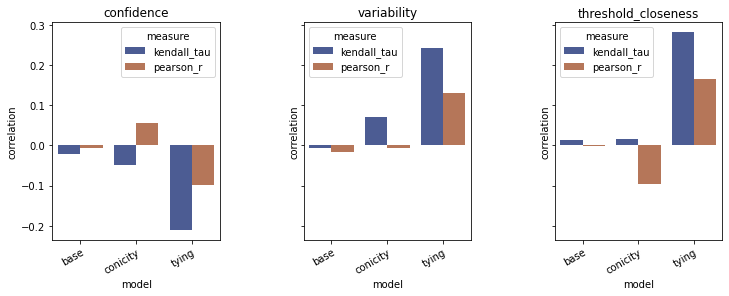

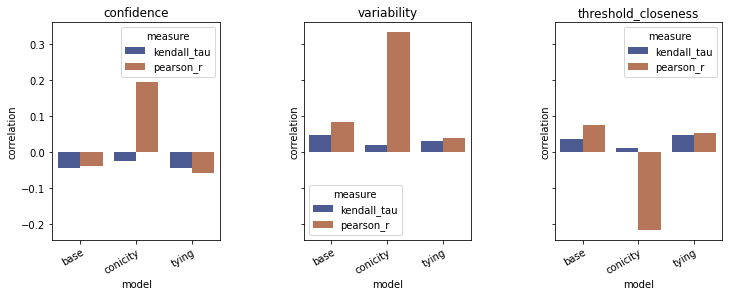

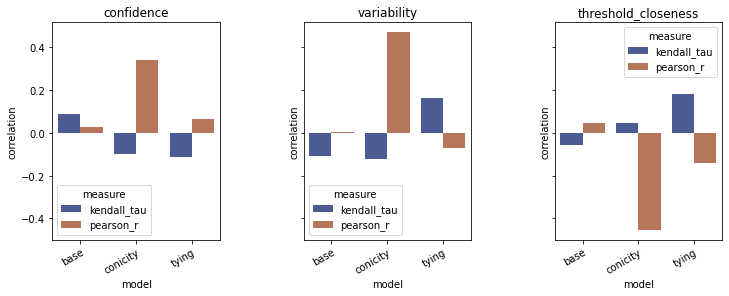

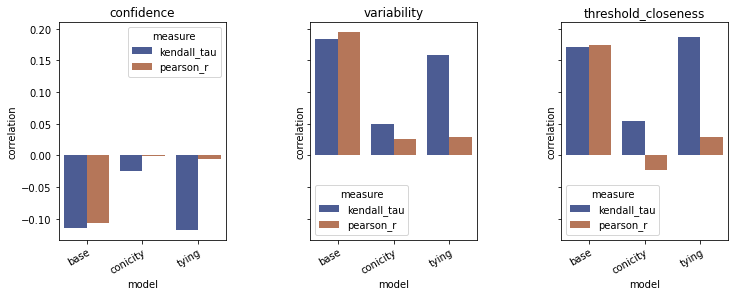

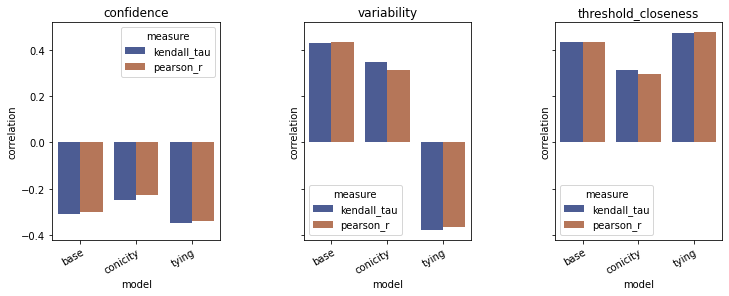

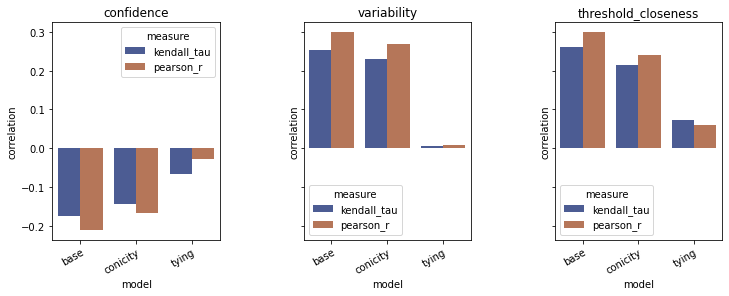

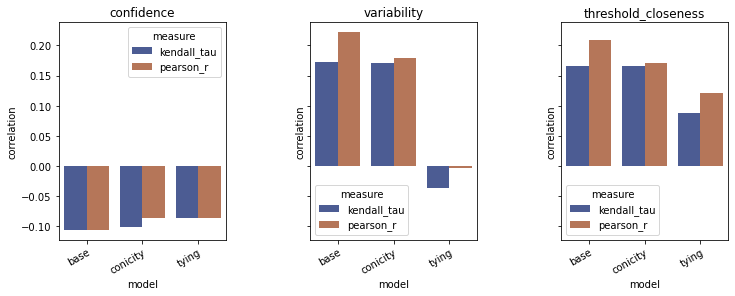

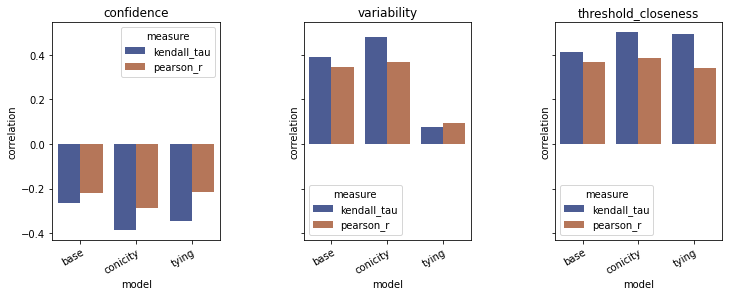

In [123]:
for model, dataset in product(models, datasets):
    print(f"{model} -- {dataset}")
    print("="*100)
    experiments = load_results(base_dir=RESULT_PATH, dataset=dataset, model=model)
    picks, names = get_best_models(experiments)
    fig = plot_attribute_matrix(picks[:-1], names[:-1], attributes=[
        "confidence",
        "variability",
        "threshold_closeness",
    ])
    plt.savefig(f"{model}-{dataset}-attr.pdf", format="pdf", bbox_inches="tight")
    

In [110]:
def plot_attribute_scatter_matrix(
    experiments,
    models,
    dataset,
    model_name,
    figsize=(10, 8),
    attributes=[
        "correctness",
        "confidence",
        "variability",
        "forgetfulness",
        "threshold_closeness",
    ],
    show_legend=True,
    print_flag=False,
):

#     fig.subplots_adjust(wspace=0.25)

    
    for j, attribute in enumerate(attributes):

        fig, axs = plt.subplots(
            1,
            figsize=figsize,
        )

        dfs = []
        for i, ((results, meta), model) in enumerate(zip(experiments, models)):
            df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(
                results, meta
            )
            df_crt_avg = cartography_average(df_crt_test)
            df_agr_i = df_agr["pearson_r"]
            df_agr_avg = agreement_average(df_agr_i)
            agreements = df_agr_avg.groupby(level=0).correlation.agg(np.mean)
            agreements = agreements.iloc[-1]
            df_new = df_crt_avg
            df_new["agreement"] = agreements
            df_new["model"] = model
            dfs.append(df_new.sample(300))
        
        palette = "Spectral"
        df_scatter = pd.concat(dfs)
        g = sns.scatterplot(
            ax=axs,
            data=df_scatter,
            x="agreement",
            y=attribute,
            hue="model",
            style="model",
            palette=[sns.color_palette(palette)[0], sns.color_palette(palette)[-1]],
            s=500,
            alpha=0.9,
        )
        
        if not show_legend:
            axs.get_legend().remove()
        else:
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, labels, markerscale=2)

        fig.savefig(f"{model_name}-{dataset}-{attribute}.pdf", format="pdf", bbox_inches="tight")
#         axs[j].get_legend().remove()
    
#     handles, labels = axs[j].get_legend_handles_labels()
#     g.legend(handles, labels, loc="right", bbox_to_anchor=(1.4, 0.5), ncol=1)
    return fig

0 0
JWA -- SUBJ


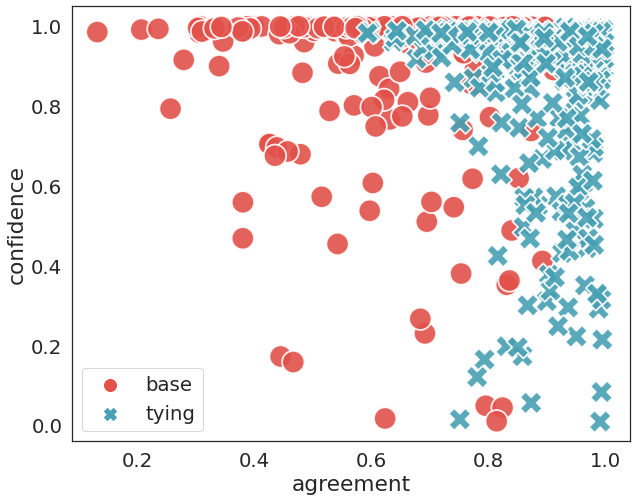

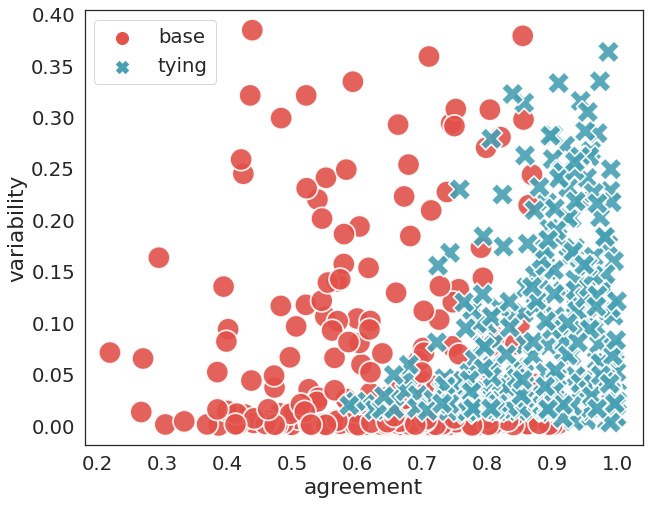

1 1
JWA -- SST


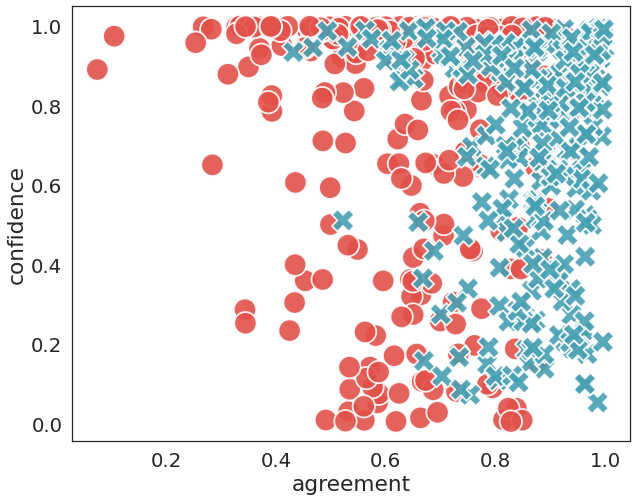

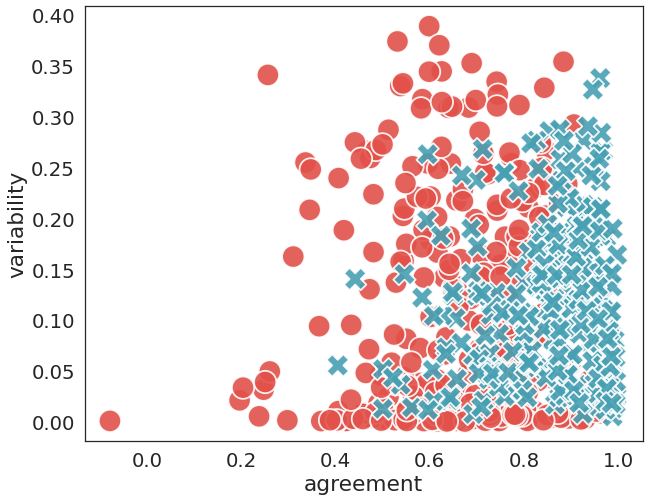

2 2
JWA -- TREC


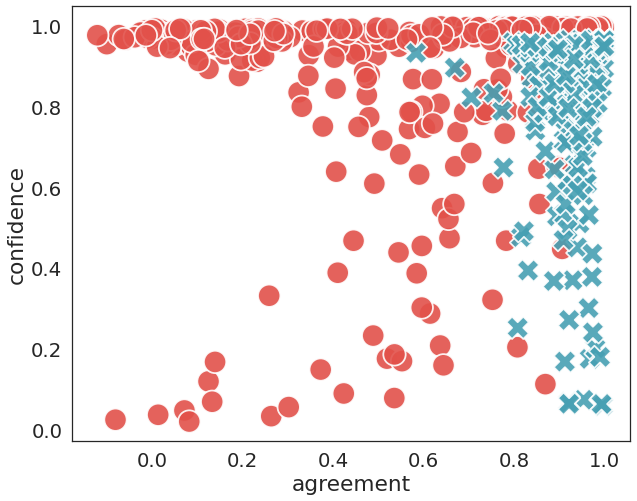

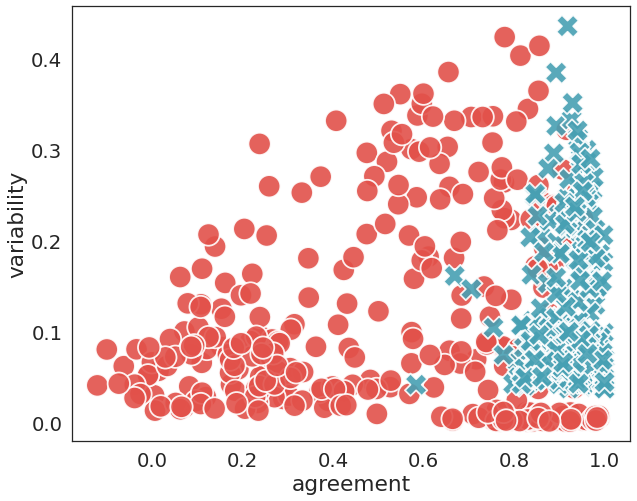

3 3
JWA -- IMDB


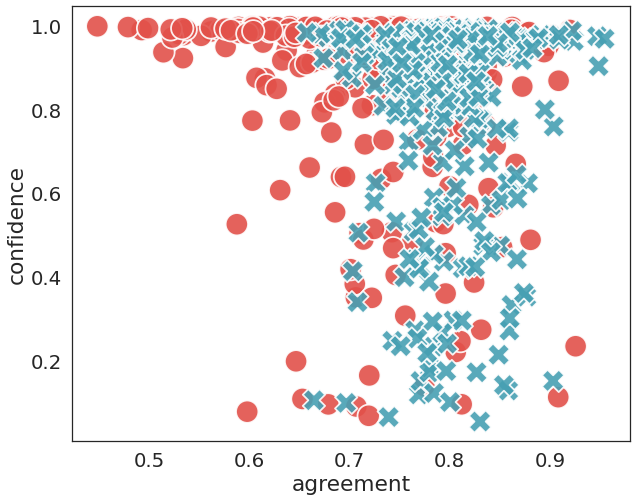

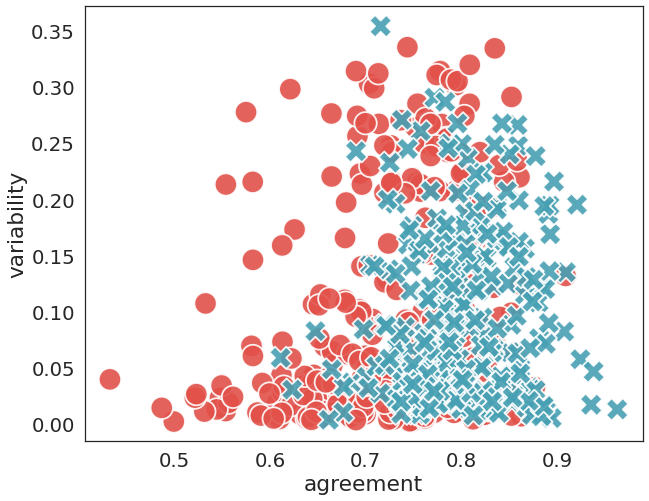

4 0
DBERT -- SUBJ


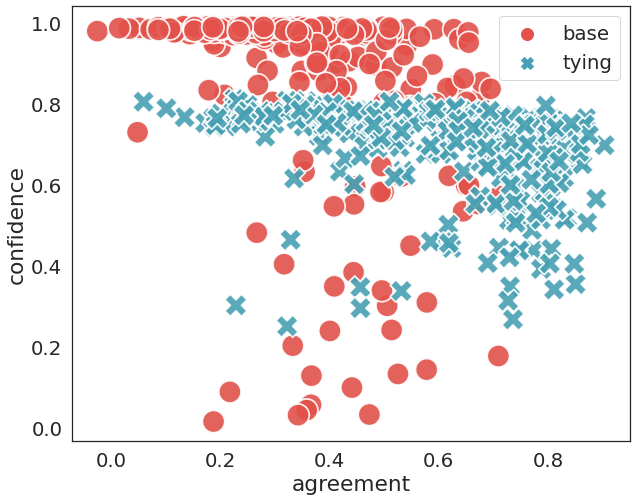

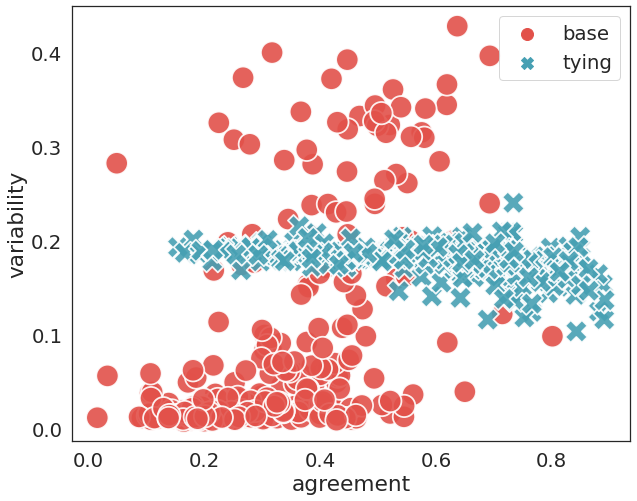

5 1
DBERT -- SST


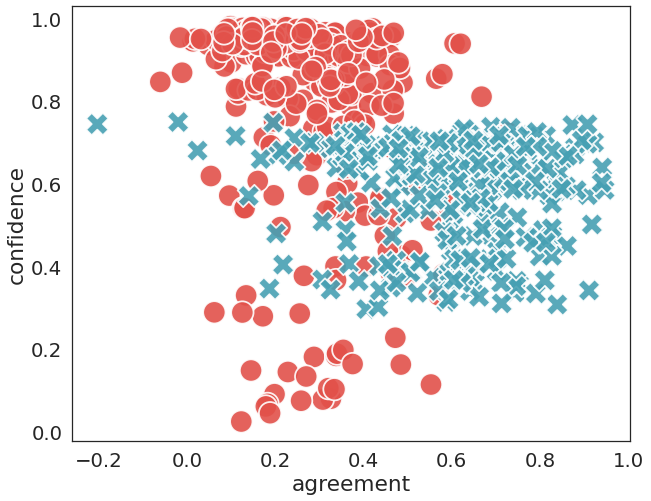

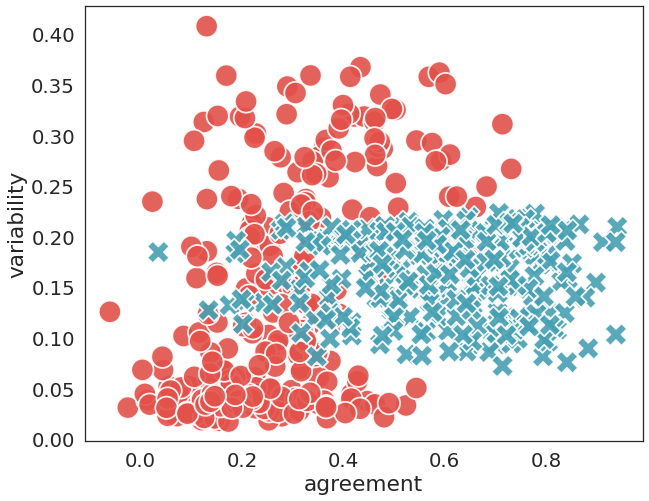

6 2
DBERT -- TREC


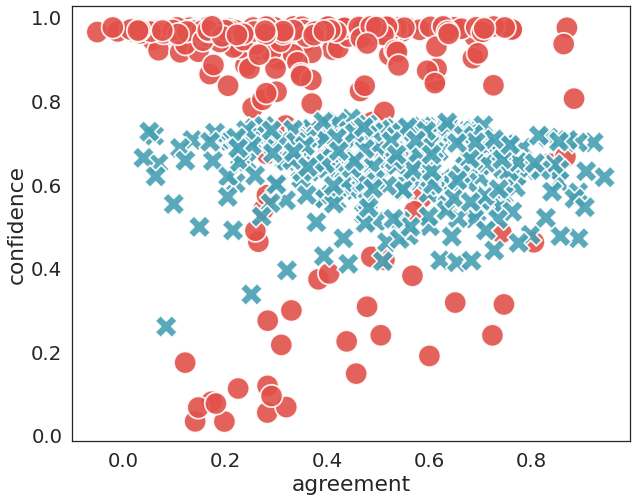

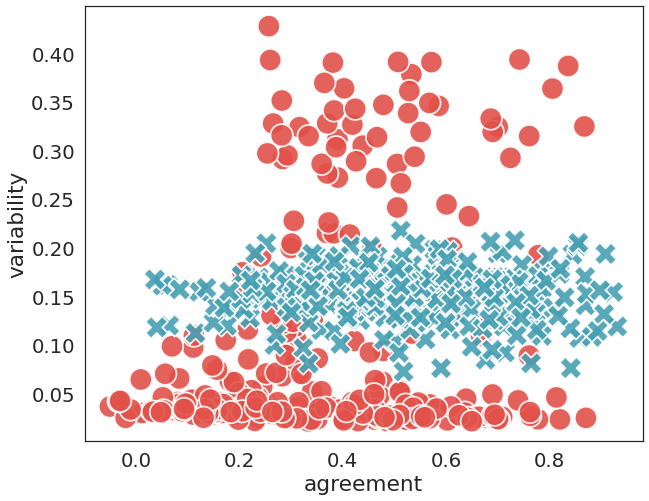

7 3
DBERT -- IMDB


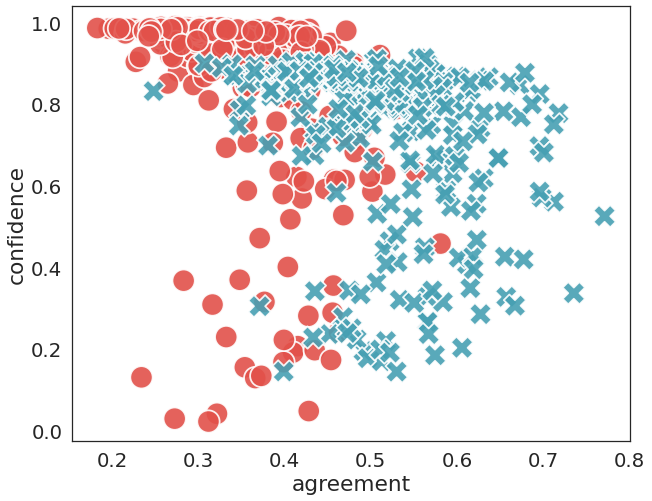

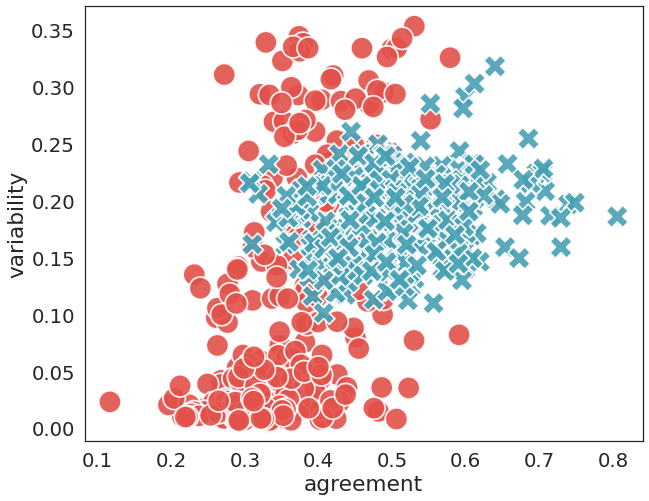

In [114]:
sns.set(font_scale = 1.8)
sns.set_style("white")
for i, (model, dataset) in enumerate(product(models, datasets)):
    print(i, i%4)
    print(f"{model} -- {dataset}")
    print("=" * 100)
    experiments = load_results(base_dir=RESULT_PATH, dataset=dataset, model=model)
    picks, names = get_best_models(experiments)
    plot_attribute_scatter_matrix(
        [picks[0], picks[2]],
        ["base", "tying"],
        dataset=dataset,
        model_name=model,
        attributes=[
            "confidence",
            "variability",
        ],
        show_legend=((i%4)==0),
    )
#     fig.savefig(f"{model}-{dataset}-attr.pdf", format="pdf", bbox_inches="tight")
    plt.show()


In [39]:
df_agr_avg = agreement_average(df_agr["pearson_r"])

In [40]:
agreements = df_agr_avg.groupby(level=0).correlation.agg(np.mean)
df_crt_avg = cartography_average(df_crt_test)

In [41]:
conf = df_crt_avg["threshold_closeness"]

### Utilities

In [ ]:
for results, meta in experiments:
    print(f"Dataset: {meta['dataset']}")
    print(f"Model: {meta['model']}")
    print(f"Batch size: {meta['batch_size']}")
    print(f"Num epochs: {meta['epochs_per_train']}")
    print(f"Seeds: {meta['seeds']}")
    print(f"Interpreters: {meta['interpreters']}")
    print(f"Tying: {meta['tying']}")
    print(f"Conicity: {meta['conicity']}")
    print(f"L2: {meta['l2']}")
    print("-" * 100)
    df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
    plot_experiment(df_tr, df_agr, meta)
    df_corrs = plot_correlations(df_agr, df_crt_test, meta, print_flag=False)
    plt.show()
    print("=" * 100)


In [8]:
conicity = [ex for ex in experiments if ex[1]["conicity"] > 0]
tying = [ex for ex in experiments if ex[1]["tying"] > 0]
l2 = [ex for ex in experiments if ex[1]["l2"] > 0]
nonreg = [
    ex
    for ex in experiments
    if ex[1]["conicity"] == 0 and ex[1]["tying"] == 0 and ex[1]["l2"] == 0
]

In [40]:
def get_final_accuracy(exp):
    results = exp[0][0]
    return results["eval"][-1]["accuracy"]

def pick_best(exps):
    best = None
    for exp in exps:
        if not best or get_final_accuracy(exp) > get_final_accuracy(best):
            best = exp
    return best

def get_best_models(experiments):
    conicity = [ex for ex in experiments if ex[1]["conicity"] > 0]
    tying = [ex for ex in experiments if ex[1]["tying"] > 0]
    l2 = [ex for ex in experiments if ex[1]["l2"] > 0]
    nonreg = [
        ex
        for ex in experiments
        if ex[1]["conicity"] == 0. and ex[1]["tying"] == 0 and ex[1]["l2"] == 0
    ]
    
    con_pick = pick_best(conicity)
    tying_pick = pick_best(tying)
    l2_pick = pick_best(l2)
    nonreg_pick = pick_best(nonreg)
    
    return con_pick, tying_pick, l2_pick, nonreg_pick

In [ ]:
df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(picks[2][0], picks[2][1])
plot_experiment(df_tr, df_agr, picks[2][1])

In [ ]:
plot_experiment(df_tr, df_agr, picks[2][1])

In [7]:
from viz_utils import *

    
def plot_agreement_matrix(experiments, models, num_meas=3, figsize=(16, 16), set_title=True, set_legend=True):
    fig, axs = plt.subplots(len(experiments), num_meas, figsize=figsize, sharey=True)
    fig.subplots_adjust(hspace=0.4)
    for j, ((results, meta), model) in enumerate(zip(experiments, models)):
        df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
        num_meas = len(df_agr)
        lines = []
        
        for i, (k, v) in enumerate(df_agr.items()):
            g = sns.lineplot(
                ax=axs[j][i],
                data=v,
                x="epoch",
                y="agreement",
                hue="interpreter",
                style="interpreter",
                ci="sd",
                markers=True,
                dashes=True,
            )
            if set_title:
                g.set_title(f"{model} -- {k.upper()}")
            handles, labels = axs[j][i].get_legend_handles_labels()
            axs[j][i].get_legend().remove()
            g.set(xticks=range(meta["epochs_per_train"]))
        
        if set_legend and j == len(experiments) - 1:
            handles, labels = axs[j][i].get_legend_handles_labels()
            g.legend(handles, labels)
            g.legend(loc="center", bbox_to_anchor=(0, -0.5), ncol=1)
    plt.show()

In [9]:
def plot_attribute_matrix(
    experiments,
    figsize=(20, 20),
    attributes=[
        "correctness",
        "confidence",
        "variability",
        "forgetfulness",
        "threshold_closeness",
    ],
    print_flag=False,
):
    fig, axs = plt.subplots(
        len(experiments), len(attributes) + 1, figsize=figsize, sharex=True
    )
    fig.subplots_adjust(wspace=0.25)
    for j, (results, meta) in enumerate(experiments):
        df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
        df_crt_avg = cartography_average(df_crt_test)
        dfs = []
        for corr_meas, df_agr_i in df_agr.items():
            df_agr_avg = agreement_average(df_agr_i)

            corr_vals = []
            for (epoch, ip), row in df_agr_avg.iterrows():
                if epoch != meta["epochs_per_train"] - 1:
                    continue
                if print_flag:
                    print(f"Epoch {epoch}")
                    print("=" * 100)
                    print(f"\tInterpreter pair: {ip}")
                for key in attributes:
                    corr = pearsonr(row["correlation"], df_crt_avg[key])
                    val = {
                        "interpreter": ip,
                        "epoch": epoch,
                        "correlation": corr[0],
                        "p-value": corr[1],
                        "attribute": key,
                    }
                    corr_vals.append(val)
                    if print_flag:
                        print(f"\t\t agreement vs. {key}: {corr}")

                corr = pearsonr(row["correlation"], meta["test_lengths"])
                val = {
                    "interpreter": ip,
                    "epoch": epoch,
                    "correlation": corr[0],
                    "p-value": corr[1],
                    "attribute": "length",
                }
                corr_vals.append(val)
                if print_flag:
                    print(f"\t\t agreement vs. length: {corr}")
                    print()

            df = pd.DataFrame(corr_vals)
            df["measure"] = corr_meas
            dfs.append(df)

        major_df = pd.concat(dfs)
        ips = meta["interpret_pairs"]

        for i, attribute in enumerate(attributes + ["length"]):
            df_filt = major_df[major_df.attribute == attribute]
            axs[j][i].set_title(attribute)
            g = sns.barplot(
                ax=axs[j][i],
                data=df_filt,
                x="interpreter",
                y="correlation",
                hue="measure",
                ci="sd",
                palette="dark",
                alpha=0.75,
            )
            g.set_title(attribute)
            g.set_xticklabels(
                rotation=30, labels=ips, ha="right", rotation_mode="anchor"
            )

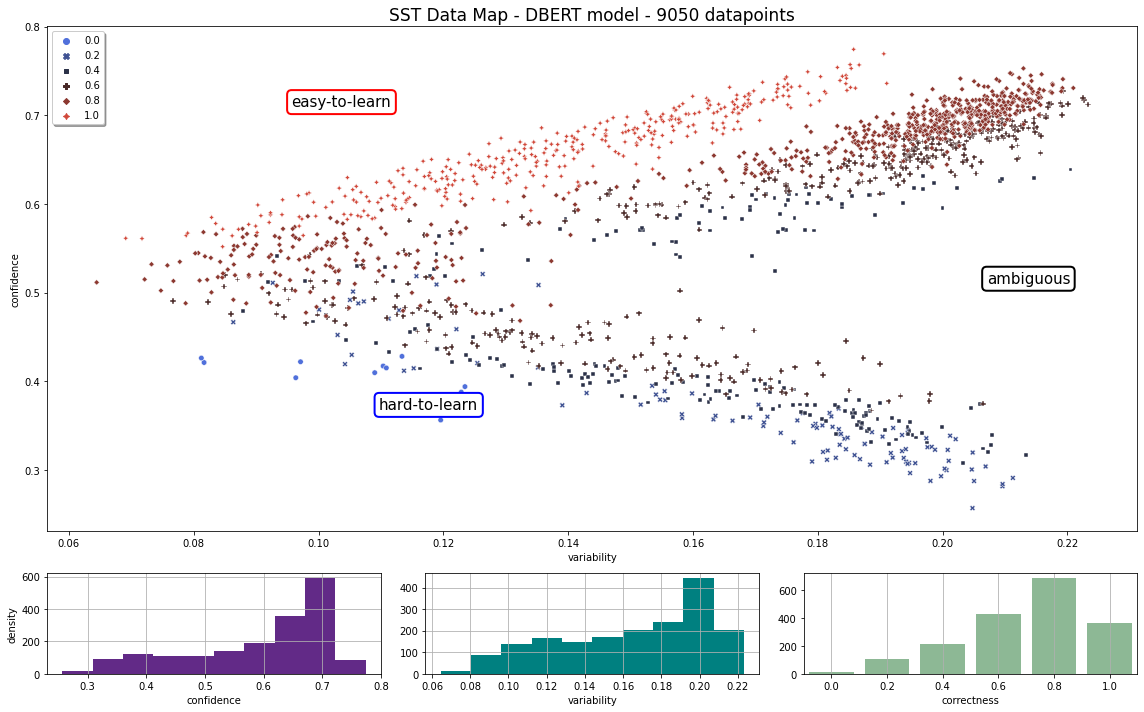

In [108]:
from util import Config

(train, val, test), vocab = load_imdb(meta=Config())
test = test[meta["test_mapping"]]

In [126]:
test[0]

Example({
    id: (None, ['2']),
    text: (None, ['let', 'start', 'off', 'by', 'first', 'saying', 'that', 'i', 'have', 'been', 'a', 'punk', 'fan', 'most', 'of', 'my', 'life', 'i', 'always', 'kind', 'of', 'had', 'a', 'lack', 'of', 'respect', 'for', 'the', 'la', 'scene', 'of', 'the', 'early', "80's", 'which', 'the', 'decline', 'of', 'western', 'civilization', 'documents', 'with', 'the', 'exception', 'of', 'x', 'and', 'black', 'flag', 'being', 'more', 'of', 'new', 'york', 'and', 'english', 'punk', 'guy', 'after', 'i', 'saw', 'this', 'movie', 'that', 'completely', 'changed', 'the', 'people', 'shown', 'may', 'look', 'like', 'a', 'bunch', 'of', 'idiotic', 'strung', 'out', 'kids', 'who', 'think', 'they', 'might', 'accomplish', 'something', 'beyond', 'street', 'cree', 'through', 'their', 'lifestyles', 'but', 'it', 'is', 'a', 'great', 'display', 'of', 'hedonism', 'at', "it's", 'best', 'coupled', 'with', 'some', 'fun', 'loud', 'rock', 'n', 'roll', 'one', 'of', 'the', 'best', 'scenes', 'and', 'a

In [12]:
test = test[meta["test_mapping"]]

In [13]:
avg = cartography_average(df_crt_test)
avg

correctness  confidence  variability  forgetfulness  \
example                                                        
0                5.0    0.938105     0.067112            0.0   
1                5.0    0.980910     0.021818            0.0   
2                5.0    0.984500     0.020590            0.0   
3                5.0    0.965507     0.032687            0.0   
4                5.0    0.912280     0.104468            0.0   
...              ...         ...          ...            ...   
4358             5.0    0.980281     0.010739            0.0   
4359             5.0    0.917346     0.070972            0.0   
4360             5.0    0.974695     0.016166            0.0   
4361             5.0    0.943790     0.078279            0.0   
4362             5.0    0.947129     0.066937            0.0   

         threshold_closeness  
example                       
0                   0.057901  
1                   0.018710  
2                   0.015254  
3                   0.033211  
4                   0.079403  
...                      ...  
4358                0.019328  
4359                0.074452  
4360                0.024659  
4361                0.052922  
4362                0.049872  

[4363 rows x 5 columns]

In [14]:
attr_avg = attribution_average(df_attr)

In [15]:
attr_avg

Empty DataFrame
Columns: []
Index: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (0, 92), (0, 93), (0, 94), (0, 95), (0, 96), (0, 97), (0, 98), (0, 99), ...]

[21815 rows x 0 columns]

In [129]:
corr_meas = "kendall_tau"
df_c = df_crt_test[df_crt_test.index.get_level_values("experiment") == 0]
df_agr_i = df_agr[corr_meas]
df_a = df_agr_i[(df_agr_i.index.get_level_values("experiment") == 0) & (df_agr_i.index.get_level_values("epoch") == 4)]
df_t = df_attr[(df_attr.index.get_level_values("experiment") == 0) & (df_attr.index.get_level_values("epoch") == 4)]
df_t = df_t.reset_index().set_index("example")
correctness = df_c.correctness.to_numpy()

(0.46860259257807485, 2.599551022152225e-12)


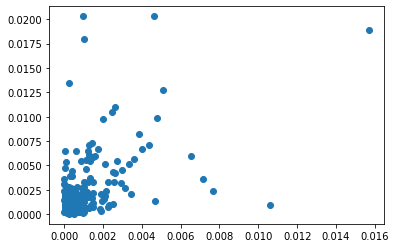

In [179]:
from scipy.stats import pearsonr

ind = 504
x = df_t.iloc[ind]["deeplift"]
y = df_t.iloc[ind]["grad-shap"]
print(pearsonr(x, y))
plt.scatter(x, y)

In [272]:
from scipy.stats import pearsonr, kendalltau


# x = np.array([.71, .02, .78, .00, 1., .01, .03, .86, .92, .02])
# y = np.array([1., .01, .92, .00, .71, .02, .03, .78, .86, .04])

x = np.array([.01, .02, .03, .04, .05, .06, 1.])
y = np.array([.06, .05, .04, .03, .02, .01, .80])

In [273]:
pearsonr(x, y)

(0.9944098749466839, 4.4741013765588384e-06)

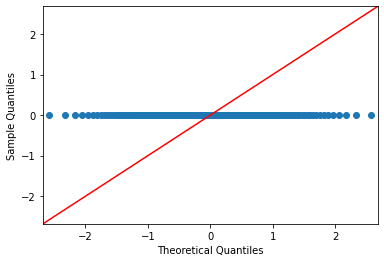

In [161]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(x, line='45')
plt.show()

In [130]:
ip = ("deeplift", "grad-shap")

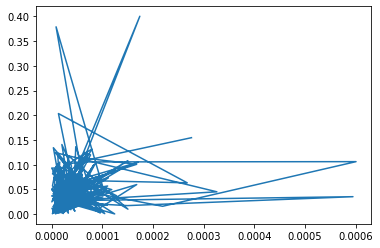

In [82]:
r = df_agr["pearson_r"].iloc[-1].correlation
tau = df_agr["kendall_tau"].iloc[-1].correlation

In [83]:
inds = tau > r

In [206]:
texts = []
tokens = []
types = []
labels = []

LABEL_MAP = {"0": "negative", "1": "positive"}
# LABEL_MAP = {"objective": "objective", "subjective": "subjective"}
for i, ex in enumerate(test):
    texts.append(ex.text[0])
    toks = ex.text[1]
    tokens.append(toks)
    labels.append(LABEL_MAP[ex.label[1]])


df_text = pd.DataFrame(
    {
        "text": texts,
        "tokens": tokens,
        "label": labels,
        "correct": df_c.correctness,
        "(deeplift, grad-shap)": df_a.iloc[0].correlation,
        "(deeplift, int-grad)": df_a.iloc[1].correlation,
        "(grad-shap, int-grad)": df_a.iloc[2].correlation,
    }
)
df_text = df_text.reset_index().set_index("example")
df_exs = pd.concat([df_text, df_t], axis=1)

In [207]:
# ip_str = "(deeplift, int-grad)"
ip_str = "(deeplift, grad-shap)"


d1 = df_exs.sort_values(ip_str)[:20]
d2 = df_exs.sort_values(ip_str)[-20:]
d12 = pd.concat([d1, d2])

In [100]:
d1 = df_exs[inds]

In [208]:
import matplotlib
from spacy import displacy
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.preprocessing import normalize
from scipy.stats import kendalltau
from scipy.stats import rankdata


TPL_TOK = """
<mark class="entity" style="background: {bg}; padding: 0.45em 0.6em; margin: 0 0.05em; line-height: 1; border-radius: 0.01em; box-decoration-break: clone; -webkit-box-decoration-break: clone">
    {text}
</mark>
"""

cmap = sns.color_palette("coolwarm", as_cmap=True)


def example_viz(example, interpreter="deeplift"):
    mms = MMS((0, 256))
    colors = (
        mms.fit_transform(example[interpreter].reshape(-1, 1)).ravel().astype(np.int32)
    )
    colors = {
        str(i): matplotlib.colors.to_hex(cmap(c), keep_alpha=True)
        for i, c in enumerate(colors)
    }

    ents = []
    ii = 0
    for itok in range(len(example.tokens)):
        ff = ii + len(example.tokens[itok])
        ent = {
            "start": ii,
            "end": ff,
            "label": str(itok),
        }
        ents.append(ent)
        ii = ff

    to_render = {
        "text": "".join(example.tokens),
        "ents": ents,
    }

    html = displacy.render(
        to_render,
        style="ent",
        manual=True,
        jupyter=True,
        options={"colors": colors, "template": TPL_TOK},
    )

    return html


def norm(v):
    return normalize(v.reshape(-1, 1)).ravel()


def example_agreement_viz(example, interpret_pair):
    mms = MMS((0, 256))
    w1 = example[interpret_pair[0]]
    w2 = example[interpret_pair[1]]
    r1 = rankdata(-w1, method="ordinal")
    r2 = rankdata(-w2, method="ordinal")
    tau, p_value = kendalltau(w1, w2)
    print(f"Agreement {interpret_pair}: [Kendall's tau = {tau}] [p-val = {p_value}]")
    agreement = w1.size - np.fabs(r1 - r2)
    colors = mms.fit_transform(agreement.reshape(-1, 1)).ravel().astype(np.int32)
    colors = {
        str(i): matplotlib.colors.to_hex(cmap(c), keep_alpha=True)
        for i, c in enumerate(colors)
    }

    ents = []
    ii = 0
    for itok in range(len(example.tokens)):
        ff = ii + len(example.tokens[itok])
        ent = {
            "start": ii,
            "end": ff,
            "label": str(itok),
        }
        ents.append(ent)
        ii = ff

    to_render = {
        "text": "".join(example.tokens),
        "ents": ents,
    }

    html = displacy.render(
        to_render,
        style="ent",
        manual=True,
        jupyter=True,
        options={"colors": colors, "template": TPL_TOK},
    )

    return html


ip = ("deeplift", "grad-shap")


for ind, i in enumerate(range(len(d12))):
    ex = d12.iloc[i]
    print(f"Example no. {ind}")
    print("-" * 100)
    print(ex.text)
    print()
    print(f"Sentiment: {ex.label}")
    print(f"Cartography: {ex.correct}")
    print("-" * 100)
    for interpreter in ["deeplift", "grad-shap"]:
        print(f"Interpreter: {interpreter}")
        example_viz(ex, interpreter=interpreter)
        print("-" * 100)
    
#     print(f"Aggrement between {ip}")
    example_agreement_viz(d12.iloc[i], ip)

Example no. 0
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.2777777777777778] [p-val = 0.35848765432098767]


Example no. 1
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.23186344238975817] [p-val = 0.04044056051325223]


Example no. 2
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.2] [p-val = 0.7194444444444444]


Example no. 3
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.09714285714285714] [p-val = 0.31953297149932736]


Example no. 4
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.14155844155844158] [p-val = 0.12338431053822567]


Example no. 5
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.01548821548821549] [p-val = 0.8673941088573982]


Example no. 6
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.08591466978375219] [p-val = 0.3363990262490012]


Example no. 7
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.030303030303030304] [p-val = 0.6946004165046488]


Example no. 8
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.10741971207087486] [p-val = 0.3100363372653203]


Example no. 9
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.01754385964912281] [p-val = 0.8471565099266034]


Example no. 10
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.07961696306429547] [p-val = 0.27775105745675266]


Example no. 11
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.08305647840531562] [p-val = 0.4325083682789409]


Example no. 12
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.1120253164556962] [p-val = 0.14135860483282825]


Example no. 13
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 0
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.018118059614260665] [p-val = 0.8393506826425862]


Example no. 14
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.1116883116883117] [p-val = 0.22413123338964558]


Example no. 15
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.03557692307692308] [p-val = 0.6752581537654916]


Example no. 16
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.18418079096045198] [p-val = 0.03759855441978327]


Example no. 17
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.049959049959049956] [p-val = 0.4370064312596521]


Example no. 18
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.04961565338923829] [p-val = 0.5963279051053383]


Example no. 19
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.04723346828609987] [p-val = 0.6720103466663802]


Example no. 20
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 3
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.25396825396825395] [p-val = 0.060059531543241174]


Example no. 21
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.12279025322503583] [p-val = 0.08298556415395361]


Example no. 22
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 1
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.30964824120603013] [p-val = 7.434571067972301e-11]


Example no. 23
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.32134831460674157] [p-val = 7.27367466301718e-06]


Example no. 24
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.1899955564019552] [p-val = 0.00016638877772589853]


Example no. 25
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 2
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.20241206030150752] [p-val = 2.076153803763523e-05]


Example no. 26
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.012519561815336462] [p-val = 0.87637992991621]


Example no. 27
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 1
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.2728592162554427] [p-val = 0.003924290706727917]


Example no. 28
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 0
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.34664842681258545] [p-val = 2.2930683420126753e-06]


Example no. 29
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 3
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.37928007023705] [p-val = 4.796461490548265e-06]


Example no. 30
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 1
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.09765564353361281] [p-val = 0.1234768964495713]


Example no. 31
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 2
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.27694728560188825] [p-val = 5.0792453618582656e-06]


Example no. 32
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.2523138832997988] [p-val = 0.0018570120113074646]


Example no. 33
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 1
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.08846153846153848] [p-val = 0.2975531675111378]


Example no. 34
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 0
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.27035175879396983] [p-val = 1.30622299826786e-08]


Example no. 35
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 3
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.25024342745861733] [p-val = 0.0010989245904319271]


Example no. 36
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.1553030303030303] [p-val = 0.21124423821567256]


Example no. 37
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.1450719822812846] [p-val = 0.1703842810882269]


Example no. 38
----------------------------------------------------------------------------------------------------
None

Sentiment: negative
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = -0.028651292802236192] [p-val = 0.7596987003155378]


Example no. 39
----------------------------------------------------------------------------------------------------
None

Sentiment: positive
Cartography: 1
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.36645962732919257] [p-val = 7.235260911876842e-06]


In [ ]:
# from podium import Vocab, Field, LabelField
# from podium.datasets import SST

# vocab = Vocab(max_size=5000, specials=())
# text = Field(name='text', numericalizer=vocab, disable_batch_matrix=True)
# label = LabelField(name='label')
# fields = {'text': text, 'label': label}
# train, dev, test = SST.get_dataset_splits(fields=fields)
# train.finalize_fields()
# x, y = train.batch(add_padding=True)

# from podium.vectorizers import TfIdfVectorizer
# tfidf_vectorizer = TfIdfVectorizer()
# tfidf_vectorizer.fit(train, field=train.field('text'))
# tfidf_x = tfidf_vectorizer.transform(x)

# train = train[train.text.str.split().str.len() >= 3]
# train.to_csv("data/SST/JWA/dev.csv", header=False)

In [201]:
dff = df_attr[df_attr.index.get_level_values("epoch") == 4]

In [202]:
dff

deeplift  \
experiment epoch example                                                      
0          4     0        [7.729783e-06, 1.1839386e-06, 3.5581845e-06, 5...   
                 1        [7.751394e-06, 6.4461115e-06, 9.176051e-06, 9....   
                 2        [0.124833554, 0.055059657, 0.119501285, 0.0252...   
                 3        [1.0803405e-05, 7.1039176e-06, 8.323852e-05, 6...   
                 4        [9.81049e-06, 4.9161235e-06, 4.5830407e-06, 1....   
...                                                                     ...   
4          4     1995     [0.00022023416, 0.0001476476, 0.0002900435, 1....   
                 1996     [0.00036963957, 0.00034269586, 0.00035103777, ...   
                 1997     [3.346191e-05, 3.3279448e-05, 0.00014332405, 1...   
                 1998     [8.846965e-05, 0.00015688172, 0.0021604998, 0....   
                 1999     [0.00023303223, 4.9118655e-05, 0.00011902966, ...   

                                                              deeplift-shap  \
experiment epoch example                                                      
0          4     0        [2.9067885e-06, 2.57372e-06, 6.367146e-07, 6.2...   
                 1        [8.638017e-07, 3.247673e-05, 2.2206064e-05, 1....   
                 2        [0.005439275, 0.002495528, 3.1874544e-05, 0.00...   
                 3        [1.9230127e-05, 7.726323e-05, 7.2285384e-06, 2...   
                 4        [1.1239762e-06, 1.5220509e-06, 2.9064222e-06, ...   
...                                                                     ...   
4          4     1995     [1.48219715e-05, 4.2231826e-05, 6.266315e-05, ...   
                 1996     [0.00043765648, 0.0004639087, 0.000108238935, ...   
                 1997     [1.9440464e-05, 6.0207103e-06, 4.3954715e-06, ...   
                 1998     [0.0058180634, 0.002950978, 0.004197875, 0.004...   
                 1999     [0.0025434638, 0.0037076746, 0.00026737055, 0....   

                                                                  grad-shap  \
experiment epoch example                                                      
0          4     0        [0.09425637, 0.045394134, 0.021034725, 0.01835...   
                 1        [0.45089626, 0.15334208, 0.2058692, 0.16381797...   
                 2        [0.00050116016, 4.645408e-07, 2.1928801e-05, 0...   
                 3        [0.0041663274, 0.16694036, 0.13419291, 0.02239...   
                 4        [0.0716539, 0.12611324, 0.027741227, 0.0054666...   
...                                                                     ...   
4          4     1995     [0.07732108, 0.00896767, 0.09677701, 0.0333414...   
                 1996     [0.0009204474, 0.0029852472, 0.0023222072, 0.0...   
                 1997     [0.00907024, 0.0004734303, 0.012033882, 0.0029...   
                 1998     [0.02339517, 0.019567428, 0.030245285, 0.01739...   
                 1999     [0.5672812, 0.37035584, 0.62229526, 1.3152914,...   

                                                                   int-grad  
experiment epoch example                                                     
0          4     0        [0.04762586094847514, 0.015048014572312595, 0....  
                 1        [0.014760618576489427, 0.0027113497844999017, ...  
                 2        [0.000804082976933849, 0.001088968419582068, 0...  
                 3        [0.019352696055458918, 0.02683697135749363, 0....  
                 4        [0.008658574228659868, 0.03034529134547598, 0....  
...                                                                     ...  
4          4     1995     [0.061093001799541635, 0.07616837093850969, 0....  
                 1996     [0.40832952291857, 0.26263563524850214, 0.2926...  
                 1997     [0.20478177368267186, 0.017809230436399783, 0....  
                 1998     [0.1713737778684878, 0.08421771786093918, 0.00...  
                 1999     [0.11569471842452086,

In [37]:
EPOCH = 4

models = ["JWA"]
for model, dataset in product(models, datasets):
    print(f"{model} -- {dataset}")
    print("="*100)
    experiments = load_results(base_dir=RESULT_PATH, dataset=dataset, model=model)
    picks, names = get_best_models(experiments)
    for (results, meta), name in zip(picks, names):
        print(f"{name}")
        print("-"*100)
        df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
        df_agr_avg = agreement_average(df_agr["pearson_r"])
        df_crt_avg = cartography_average(df_crt_test)
        confidence = df_crt_avg.confidence
        variability = df_crt_avg.variability
        q1_conf = confidence.quantile(0.25)
        q3_conf = confidence.quantile(0.75)
        q1_var = variability.quantile(0.25)
        q3_var = variability.quantile(0.75)
        conf_mask_easy = confidence >= q3_conf
        var_mask_easy = variability <= variability.median()
        conf_mask_amb = confidence >= confidence.quantile(0)
        var_mask_amb = variability >= q3_var
        correlations = df_agr_avg[df_agr_avg.index.get_level_values(0) == EPOCH].correlation
        easys = []
        ambs = []
        hards = []
        avgs = []
        print(var_mask_easy.sum())
        for i, corrs in enumerate(correlations):
            easy_corrs = corrs[df_crt_avg.correctness == 5]#corrs[conf_mask_easy & var_mask_easy]
            amb_corrs = corrs[(df_crt_avg.correctness == 2) | (df_crt_avg.correctness == 3)]#corrs[var_mask_amb]
            hard_corrs = corrs[df_crt_avg.correctness == 0]
#             print(len(easy_corrs))
#             print(len(amb_corrs))
#             print(f"Easy agreement ({len(easy_corrs)})", easy_corrs.mean())
#             print(f"Ambiguous agreement ({len(amb_corrs)})", amb_corrs.mean())
#             print("Average agreement", corrs.mean())
            easys.append(easy_corrs.mean())
            ambs.append(amb_corrs.mean())
            hards.append(hard_corrs.mean())
            avgs.append(corrs.mean())
        print(f"Easy avg: {np.array(easys).mean()}")
        print(f"Amb avg: {np.array(ambs).mean()}")
        print(f"Hard avg: {np.array(hards).mean()}")
        print(f"Avgs: {np.array(avgs).mean()}")
        print("-"*100)

JWA -- SUBJ
non-reg
----------------------------------------------------------------------------------------------------
1000
Easy avg: 0.6577439966186099
Amb avg: 0.6620552434006912
Hard avg: 0.6614545125042669
Avgs: 0.6580695504788426
----------------------------------------------------------------------------------------------------
conicity
----------------------------------------------------------------------------------------------------
1000
Easy avg: 0.7057657307320149
Amb avg: 0.7032929887769841
Hard avg: 0.6982082558194067
Avgs: 0.7031819356447554
----------------------------------------------------------------------------------------------------
tying
----------------------------------------------------------------------------------------------------
1000
Easy avg: 0.8764774641104657
Amb avg: 0.9196567907483678
Hard avg: 0.8972180209857639
Avgs: 0.8837872349019867
----------------------------------------------------------------------------------------------------
l2
--------

In [35]:
def df_train_average(df, groupby=["epoch"]):
    new_df = df.groupby(groupby).aggregate("mean")
    new_df["f1_std"] = df.groupby(groupby).aggregate(np.std).test_f1
    return new_df

In [38]:
models = ["JWA"]
for model, dataset in product(models, datasets):
    print(f"{model} -- {dataset}")
    print("="*100)
    experiments = load_results(base_dir=RESULT_PATH, dataset=dataset, model=model)
    picks, names = get_best_models(experiments)
    for (results, meta), name in zip(picks, names):
        print(f"{name}")
        print("-"*100)
        df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
        df_tr = df_train_average(df_tr)
        print(df_tr)
        print(df_tr.test_f1.max())
        print("-"*100)

JWA -- SUBJ
non-reg
----------------------------------------------------------------------------------------------------
       train_loss  test_accuracy   test_f1    f1_std
epoch                                               
0        0.303249         0.9145  0.918696  0.003316
1        0.123155         0.9179  0.921596  0.005364
2        0.048149         0.9202  0.922908  0.002840
3        0.017396         0.9138  0.919126  0.004861
4        0.005730         0.9178  0.921415  0.002108
0.9229084137595827
----------------------------------------------------------------------------------------------------
conicity
----------------------------------------------------------------------------------------------------
       train_loss  test_accuracy   test_f1    f1_std
epoch                                               
0        0.642161         0.8949  0.900410  0.003111
1        0.269892         0.8919  0.897417  0.001867
2        0.045739         0.8903  0.893752  0.006117
3       -0.13

       train_loss  test_accuracy   test_f1    f1_std
epoch                                               
0        2.869835       0.852166  0.856835  0.005282
1        1.303578       0.857163  0.860592  0.002306
2        0.735383       0.843365  0.847674  0.003575
3        0.495981       0.826404  0.827521  0.003327
4        0.387110       0.814210  0.807810  0.002175
0.8605924565002155
----------------------------------------------------------------------------------------------------
l2
----------------------------------------------------------------------------------------------------
       train_loss  test_accuracy   test_f1    f1_std
epoch                                               
0        0.352162       0.885767  0.889890  0.002053
1        0.196256       0.890442  0.888833  0.004103
2        0.106881       0.881137  0.880186  0.004907
3        0.042933       0.864543  0.873802  0.004178
4        0.013666       0.870273  0.867171  0.010381
0.8898902961368854
---------------

In [25]:
a = np.array([.48,.03,.22,.08])
a.mean()

0.20249999999999999

In [83]:
def acs(df, meta, agreement, subsample=None, show_hist=True, rs=42):
    dataframe = cartography_average(df)
    dataframe["agreement"] = agreement
    if subsample:
        dataframe = dataframe.sample(
            n=subsample, random_state=rs
        )
    dataframe = dataframe.sort_values("agreement")
    dataframe["weights"] = dataframe.agreement
    dataframe = dataframe[dataframe.agreement >= 0.]
    dataframe["agreement"] = [f"{x:.1f}" for x in dataframe["agreement"]]
    
 
    
    dataframe = dataframe.assign(
            corr_frac=lambda d: d.correctness / d.correctness.max()
        )
    dataframe["correct"] = [f"{x:.1f}" for x in dataframe["corr_frac"]]
    

    main_metric = "variability"
    other_metric = "confidence"
    
    hue = "agreement"
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue #if num_hues < 1 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(10, 5))
        ax0 = axs
    else:
        fig = plt.figure(
            figsize=(16, 8),
        )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])

        ax0 = fig.add_subplot(gs[0, :])

    ### Make the scatterplot.

    # Choose a palette.
    pal = reversed(sns.color_palette("magma", num_hues))
#     pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    g = sns.scatterplot(
        x=main_metric,
        y=other_metric,
        ax=ax0,
        data=dataframe,
        hue=hue,
        palette=pal,
        style=style,
        size="weights",
        sizes=(100, 400),
        alpha=0.9
    )
    

    
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[1:num_hues+1]
    labels = ["0.3", "0.4", "0.5", "0.6", "0.7", "0.8"][:num_hues]
    
    g.legend(
        handles,
        labels,
        ncol=num_hues,
        bbox_to_anchor=(0.5, -0.38),
        loc="center",
        fancybox=True,
        shadow=True,
        title="Agreement",
        markerscale=1.5,
    )
    
    leg = ax0.get_legend()
    leg._legend_box.align = "left"

    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
#     an1 = ax0.annotate(
#         "ambiguous",
#         xy=(0.9, 0.5),
#         xycoords="axes fraction",
#         fontsize=15,
#         color="black",
#         va="center",
#         ha="center",
#         bbox=bb("black"),
#     )
#     an2 = ax0.annotate(
#         "easy-to-learn",
#         xy=(0.27, 0.85),
#         xycoords="axes fraction",
#         fontsize=15,
#         color="black",
#         va="center",
#         ha="center",
#         bbox=bb("r"),
#     )
#     an3 = ax0.annotate(
#         "hard-to-learn",
#         xy=(0.35, 0.25),
#         xycoords="axes fraction",
#         fontsize=15,
#         color="black",
#         va="center",
#         ha="center",
#         bbox=bb("b"),
#     )

#     if not show_hist:
#         plot.legend(
#             ncol=1,
# #             bbox_to_anchor=(1.01, 0.5),
#             loc="best",
#             fancybox=True,
#             shadow=True,
#             title="Agreement",
#         )
# #     else:
# #         plot.legend(fancybox=True, shadow=True, ncol=1)
#     plot.set_xlabel("Variability")
#     plot.set_ylabel("Confidence")

#     if show_hist:
#         plot.set_title(
#             f"{meta['dataset']} Data Map - {meta['model']} model - {len(df)} datapoints",
#             fontsize=17,
#         )

#         # Make the histograms.
#         ax1 = fig.add_subplot(gs[1, 0])
#         ax2 = fig.add_subplot(gs[1, 1])
#         ax3 = fig.add_subplot(gs[1, 2])

#         plott0 = dataframe.hist(column=["confidence"], ax=ax1, color="#622a87")
#         plott0[0].set_title("")
#         plott0[0].set_xlabel("confidence")
#         plott0[0].set_ylabel("density")

#         plott1 = dataframe.hist(column=["variability"], ax=ax2, color="teal")
#         plott1[0].set_title("")
#         plott1[0].set_xlabel("variability")

#         plot2 = sns.countplot(x="correct", data=dataframe, color="#86bf91", ax=ax3)
#         ax3.xaxis.grid(True)  # Show the vertical gridlines

#         plot2.set_title("")
#         plot2.set_xlabel("correctness")
#         plot2.set_ylabel("")


    fig.tight_layout()
    return fig

DBERT -- SUBJ


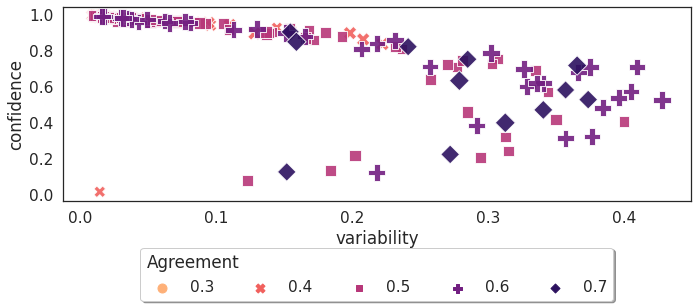

In [84]:
sns.set(font_scale = 1.4)
sns.set_style("white")
for model, dataset in product(["DBERT"], ["SUBJ"]):
    print(f"{model} -- {dataset}")
    print("="*100)
    experiments = load_results(base_dir=RESULT_PATH, dataset=dataset, model=model)
    picks, names = get_best_models(experiments)
    for (results, meta), name in zip(picks[:1], names[:1]):
        df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
        df_agr_avg = agreement_average(df_agr["kendall_tau"])
        agreements = df_agr_avg.groupby(level=0).correlation.agg(np.mean)
        agr = agreements[agreements.index.get_level_values(0) == 4]
        fig = acs(df_crt_test, meta, agr.iloc[0], subsample=250, show_hist=False, rs=1)
#         print(f"[{name.upper()}] Mean: {agr.mean().round(2)}, std: {agr.std():.3f}")
#         print(name)
        plt.show()
        fig.savefig(f"{model}-{dataset}-crt-agr.pdf", format="pdf", bbox_inches="tight")
    break

DBERT -- SUBJ


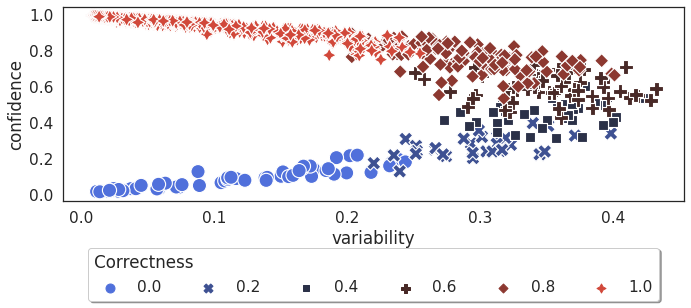

In [82]:
sns.set(font_scale = 1.4)
sns.set_style("white")

for model, dataset in product(["DBERT"], ["SUBJ"]):
    print(f"{model} -- {dataset}")
    print("="*100)
    experiments = load_results(base_dir=RESULT_PATH, dataset=dataset, model=model)
    picks, names = get_best_models(experiments)
    for (results, meta), name in zip(picks[:1], names[:1]):
        df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
        fig = plot_cartography(df_crt_test, meta, hue_metric="correct", show_hist=False)
#         print(f"[{name.upper()}] Mean: {agr.mean().round(2)}, std: {agr.std():.3f}")
#         print(name)
        plt.show()
        fig.savefig(f"{model}-{dataset}-crt-corr.pdf", format="pdf", bbox_inches="tight")
    break

In [93]:
dfs = []

for model, dataset in product(["JWA"], ["SUBJ"]):
    print(f"{model} -- {dataset}")
    print("="*100)
    experiments = load_results(base_dir=RESULT_PATH, dataset=dataset, model=model)
    picks, names = get_best_models(experiments)
    for (results, meta), name in zip(picks[:3], names[:3]):
        df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
        df_avg_crt = cartography_average(df_crt_test)
        df_agr = df_agr["kendall_tau"]
        df_agr = df_agr[df_agr.index.get_level_values("epoch") == 4]
        df_agr = df_agr.groupby(level=[0]).agreement.agg(np.mean)
        new_df = pd.DataFrame({"agreement": df_agr, "model": [name]*len(df_agr)})
        
        dfs.append(new_df)
        
df = pd.concat(dfs)

JWA -- SUBJ


In [92]:
x = df[df.model == "non-reg"].agreement.to_numpy()
y = df[df.model == "conicity"].agreement.to_numpy()
z = df[df.model == "tying"].agreement.to_numpy()

print(z.mean(), y.mean())

print(f"C-B: {wilcoxon(y, x, alternative='greater')}")
print(f"T-B: {wilcoxon(z, x, alternative='greater')}")
print(f"T-C: {wilcoxon(z, y, alternative='greater')}")
print(f"C-T: {wilcoxon(y, z, alternative='greater')}")

0.6765899125789663 0.6726539563383745
C-B: WilcoxonResult(statistic=15.0, pvalue=0.03125)
T-B: WilcoxonResult(statistic=15.0, pvalue=0.03125)
T-C: WilcoxonResult(statistic=10.0, pvalue=0.3125)
C-T: WilcoxonResult(statistic=5.0, pvalue=0.78125)


In [51]:
z.mean()

0.5684644342023296

In [68]:
from scipy.stats import wilcoxon
from itertools import combinations

for (i, j) in combinations([x, y, z], 2):
    print(i, j)
    print(wilcoxon(j, i, alternative="greater"))

[0.33759848 0.33759848 0.28885513 0.28885513 0.31489998 0.31489998
 0.32928097 0.32928097 0.29803879 0.29803879] [0.49909951 0.49909951 0.47140474 0.47140474 0.49896859 0.49896859
 0.51845075 0.51845075 0.42016781 0.42016781]
WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
[0.33759848 0.33759848 0.28885513 0.28885513 0.31489998 0.31489998
 0.32928097 0.32928097 0.29803879 0.29803879] [0.54123558 0.54123558 0.59592858 0.59592858 0.5838643  0.5838643
 0.58665233 0.58665233 0.53464138 0.53464138]
WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
[0.49909951 0.49909951 0.47140474 0.47140474 0.49896859 0.49896859
 0.51845075 0.51845075 0.42016781 0.42016781] [0.54123558 0.54123558 0.59592858 0.59592858 0.5838643  0.5838643
 0.58665233 0.58665233 0.53464138 0.53464138]
WilcoxonResult(statistic=55.0, pvalue=0.0009765625)


In [14]:
dfs = []

for model, dataset in product(["DBERT"], ["SUBJ"]):
    print(f"{model} -- {dataset}")
    print("=" * 100)
    experiments = load_results(base_dir=RESULT_PATH, dataset=dataset, model=model)
    picks, names = get_best_models(experiments)
    results, meta = picks[0]
    df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
    
    df_avg_crt = cartography_average(df_crt_test)
    df_avg_agr = df_agr["pearson_r"]
    corrs = df_avg_agr.groupby(level=[0, 1]).correlation.agg(np.mean)
    df = pd.DataFrame(
        {
            "agreement": corrs,
            "confidence": df_avg_crt.confidence,
            "variability": df_avg_crt.variability,
            "correctness": df_avg_crt.correctness,
            "threshold_closeness": df_avg_crt.threshold_closeness,
        }
    )
    df["source"] = dataset
    df = df.reset_index().set_index(["example", "source"])
    dfs.append(df)
    
    
new_df = pd.concat(dfs)

DBERT -- SUBJ


NotImplementedError: Can only union MultiIndex with MultiIndex or Index of tuples, try mi.to_flat_index().union(other) instead.

In [16]:
corrs

experiment  epoch
0           0        [0.6896960963231781, 0.7084097076892365, 0.812...
            1        [0.6284511833396987, 0.5998157912225229, 0.717...
            2        [0.22259184170273608, 0.20884675103966055, 0.7...
            3        [0.23959169493079316, 0.3112729425212326, 0.83...
            4        [0.2645380795771543, 0.3818080133126404, 0.687...
1           0        [0.6323753748989361, 0.6373035375146351, 0.430...
            1        [0.4432138982808523, 0.5869370175752375, 0.716...
            2        [0.30261579514162046, 0.48614250444217805, 0.5...
            3        [0.21841163798720997, 0.41048961718811094, 0.4...
            4        [0.2637710263674848, 0.14875534157759138, 0.50...
2           0        [0.5828075869389319, 0.5697462938031775, 0.640...
            1        [0.3042755360191659, 0.34008592333213633, 0.59...
            2        [0.24776210349140126, 0.2595683746278921, 0.58...
            3        [0.20008722750832963, 0.24316671477576

In [3]:
dfs = []

for model, dataset in product(["DBERT"], ["SUBJ", "TREC", "SST", "IMDB"]):
    print(f"{model} -- {dataset}")
    print("=" * 100)
    experiments = load_results(base_dir=RESULT_PATH, dataset=dataset, model=model)
    picks, names = get_best_models(experiments)
    results, meta = picks[0]
    df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
    
    df_avg_crt = cartography_average(df_crt_test)
    df_avg_agr = agreement_average(df_agr["pearson_r"])
    corrs = df_avg_agr.groupby(level=0).correlation.agg(np.mean).iloc[2]
    df = pd.DataFrame(
        {
            "agreement": corrs,
            "confidence": df_avg_crt.confidence,
            "variability": df_avg_crt.variability,
            "correctness": df_avg_crt.correctness,
            "threshold_closeness": df_avg_crt.threshold_closeness,
        }
    )
    df["source"] = dataset
    df = df.reset_index().set_index(["example", "source"])
    dfs.append(df)
    
    
new_df = pd.concat(dfs)

DBERT -- SUBJ
DBERT -- TREC
DBERT -- SST
DBERT -- IMDB


In [4]:
new_df

agreement  confidence  variability  correctness  \
example source                                                    
0       SUBJ     0.344175    0.953987     0.092483          5.0   
1       SUBJ     0.315799    0.966997     0.061985          5.0   
2       SUBJ     0.642540    0.496376     0.394225          2.0   
3       SUBJ     0.346553    0.953437     0.092802          5.0   
4       SUBJ     0.237438    0.992003     0.009148          5.0   
...                   ...         ...          ...          ...   
4358    IMDB     0.266692    0.980281     0.010739          5.0   
4359    IMDB     0.491053    0.917346     0.070972          5.0   
4360    IMDB     0.284527    0.974695     0.016166          5.0   
4361    IMDB     0.434674    0.943790     0.078279          5.0   
4362    IMDB     0.057193    0.947129     0.066937          5.0   

                threshold_closeness  
example source                       
0       SUBJ               0.043592  
1       SUBJ               0.031779  
2       SUBJ               0.225445  
3       SUBJ               0.044278  
4       SUBJ               0.007932  
...                             ...  
4358    IMDB               0.019328  
4359    IMDB               0.074452  
4360    IMDB               0.024659  
4361    IMDB               0.052922  
4362    IMDB               0.049872  

[8659 rows x 5 columns]

In [10]:
new_df.corr()

agreement  confidence  variability  correctness  \
agreement             1.000000   -0.271411     0.436710    -0.226033   
confidence           -0.271411    1.000000    -0.629177     0.973138   
variability           0.436710   -0.629177     1.000000    -0.547737   
correctness          -0.226033    0.973138    -0.547737     1.000000   
threshold_closeness   0.423159   -0.654908     0.972114    -0.565090   

                     threshold_closeness  
agreement                       0.423159  
confidence                     -0.654908  
variability                     0.972114  
correctness                    -0.565090  
threshold_closeness             1.000000

In [11]:
new_df

agreement  confidence  variability  correctness  \
example source                                                    
0       SUBJ     0.344175    0.953987     0.092483          5.0   
1       SUBJ     0.315799    0.966997     0.061985          5.0   
2       SUBJ     0.642540    0.496376     0.394225          2.0   
3       SUBJ     0.346553    0.953437     0.092802          5.0   
4       SUBJ     0.237438    0.992003     0.009148          5.0   
...                   ...         ...          ...          ...   
4358    IMDB     0.266692    0.980281     0.010739          5.0   
4359    IMDB     0.491053    0.917346     0.070972          5.0   
4360    IMDB     0.284527    0.974695     0.016166          5.0   
4361    IMDB     0.434674    0.943790     0.078279          5.0   
4362    IMDB     0.057193    0.947129     0.066937          5.0   

                threshold_closeness  
example source                       
0       SUBJ               0.043592  
1       SUBJ               0.031779  
2       SUBJ               0.225445  
3       SUBJ               0.044278  
4       SUBJ               0.007932  
...                             ...  
4358    IMDB               0.019328  
4359    IMDB               0.074452  
4360    IMDB               0.024659  
4361    IMDB               0.052922  
4362    IMDB               0.049872  

[8659 rows x 5 columns]

In [13]:
new_df.to_csv("dbert_agreement.csv")

In [14]:
load = pd.read_csv("dbert_agreement.csv", index_col=[0, 1])

In [16]:
load.corr()

agreement  confidence  variability  correctness  \
agreement             1.000000   -0.271411     0.436710    -0.226033   
confidence           -0.271411    1.000000    -0.629177     0.973138   
variability           0.436710   -0.629177     1.000000    -0.547737   
correctness          -0.226033    0.973138    -0.547737     1.000000   
threshold_closeness   0.423159   -0.654908     0.972114    -0.565090   

                     threshold_closeness  
agreement                       0.423159  
confidence                     -0.654908  
variability                     0.972114  
correctness                    -0.565090  
threshold_closeness             1.000000